# Обучение свёрточной нейронной сети.  
Загружаем пред обработанные данные.

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
# from six.moves import range
from matplotlib.pyplot import imshow


In [16]:
pickle_file = './model/SVHN_multi.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (229731, 32, 32, 1) (229731, 6)
Validation set (5400, 32, 32, 1) (5400, 6)
Test set (13068, 32, 32, 1) (13068, 6)


Используем приём усиливающий контрастность (разность) между схожими свойствами на одной карте свойств и на соседних картах свойств, [статья](http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf).

In [17]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """
    Local Contrast Normalization
    :param X: tf_train_dataset
    :param image_shape: [batch_size, image_size, image_size, num_channels]
    """
    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)
    # For process visualisation 
#     plt.rcParams['figure.figsize'] = (45.0, 100.0)    
#     f, ax = plt.subplots(nrows= radius * radius + 1, ncols=1)
#     [i.axis('off') for i in ax]
    ax = None
       
    filters, filters_asarray = gaussian_filter(filter_shape, ax)
    
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.subtract(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X

    return new_X


def gaussian_filter_(kernel_shape, ax):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in range(0, kernel_shape[2]):
        for i in range(0, kernel_shape[0]):
            for j in range(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)


def gaussian_filter(kernel_shape, ax):
    # The Gaussian filter of the desired size initialized to zero
    filter_ = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)  # Middle of kernel of Gaussian filter
    
    for kernel_idx in range(0, kernel_shape[2]):
        for i in range(0, kernel_shape[0]):  # go on width of Gaussian weighting window
            for j in range(0, kernel_shape[1]):  # go on height of Gaussian weighting window
                filter_[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
                # For process visualisation 
#                 _ = [i.ravel() for i in filter_] # (32, 32, 1) to (32, 32)
#                 ax[kernel_shape[0] * i + j].set_title(
#                     f"mid: {mid} i: {i} j: {j} x: {i - mid} y: {j - mid}", loc='center'
#                 )
#                 ax[kernel_shape[0] * i + j].imshow([i.ravel() for i in filter_])
    
    filter_ = filter_ / np.sum(filter_)    
    ax[kernel_shape[0] * kernel_shape[1]].set_title(f"finish", loc='center')
    ax[kernel_shape[0] * kernel_shape[1]].imshow([i.ravel() for i in filter_])
    return tf.convert_to_tensor(filter_, dtype=tf.float32), filter_


def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

# TODO
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) \
            / predictions.shape[1] / predictions.shape[0])

Арихитектура сети подробно описанна в [статье](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf).  
Конкртерные реализации: [пример в документации](https://www.tensorflow.org/tutorials/images/deep_cnn), [hangyao](https://github.com/hangyao/street_view_house_numbers).


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: nan
Minibatch accuracy: 3.8%
Validation accuracy: 5.2%
Minibatch loss at step 10000: nan
Minibatch accuracy: 8.4%
Validation accuracy: 5.2%
Minibatch loss at step 20000: nan
Minibatch accuracy: 10.3%
Validation accuracy: 5.2%
Minibatch loss at step 30000: nan
Minibatch accuracy: 10.6%
Validation accuracy: 5.2%
Minibatch loss at step 40000: nan
Minibatch accuracy: 9.4%
Validation accuracy: 5.2%
Minibatch loss at step 50000: nan
Minibatch accuracy: 5.9%
Validatio

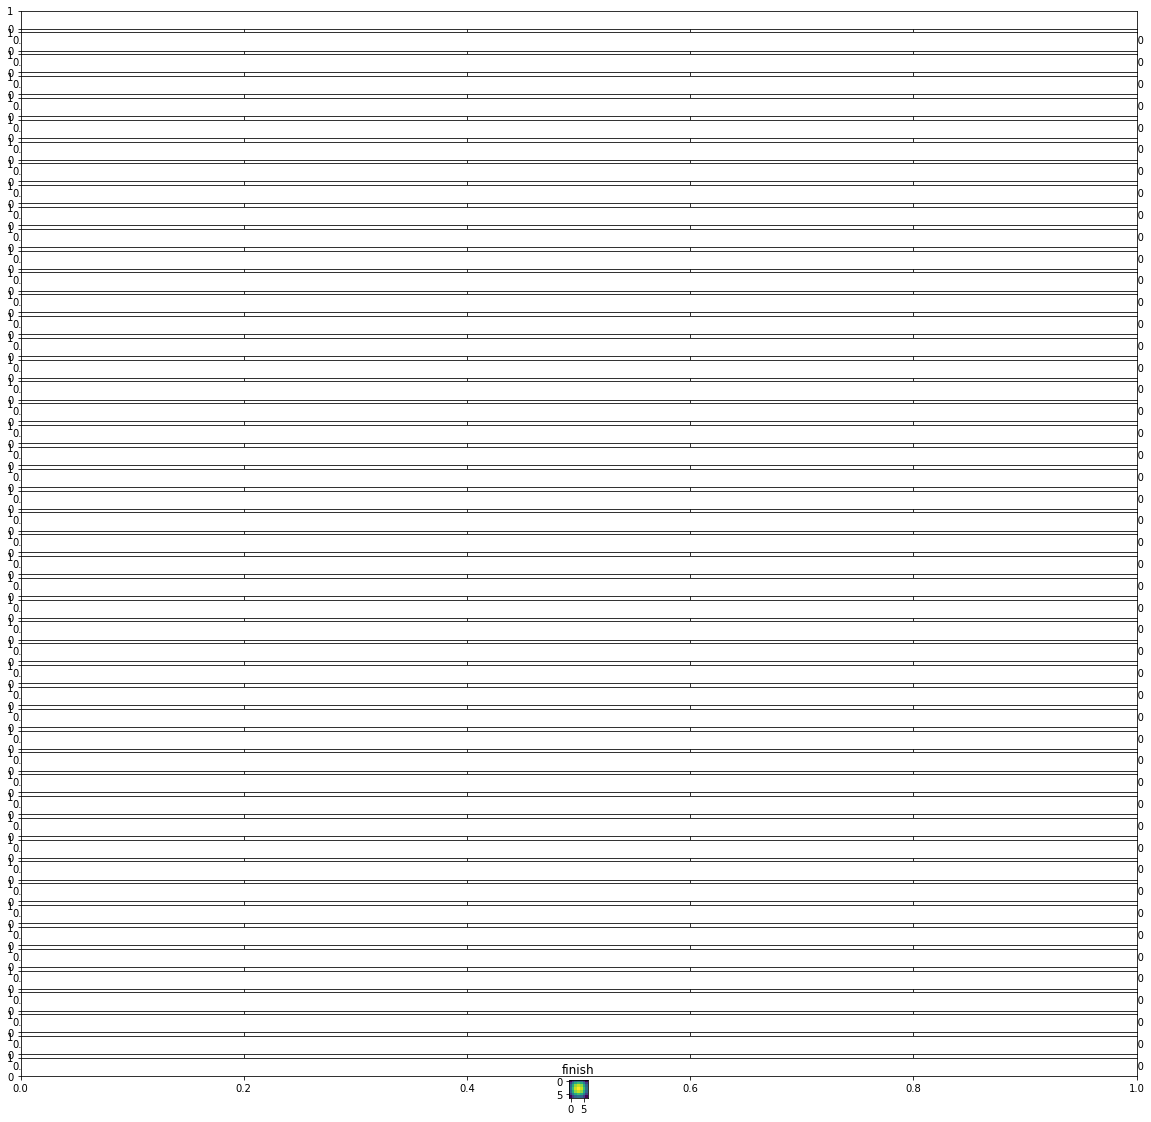

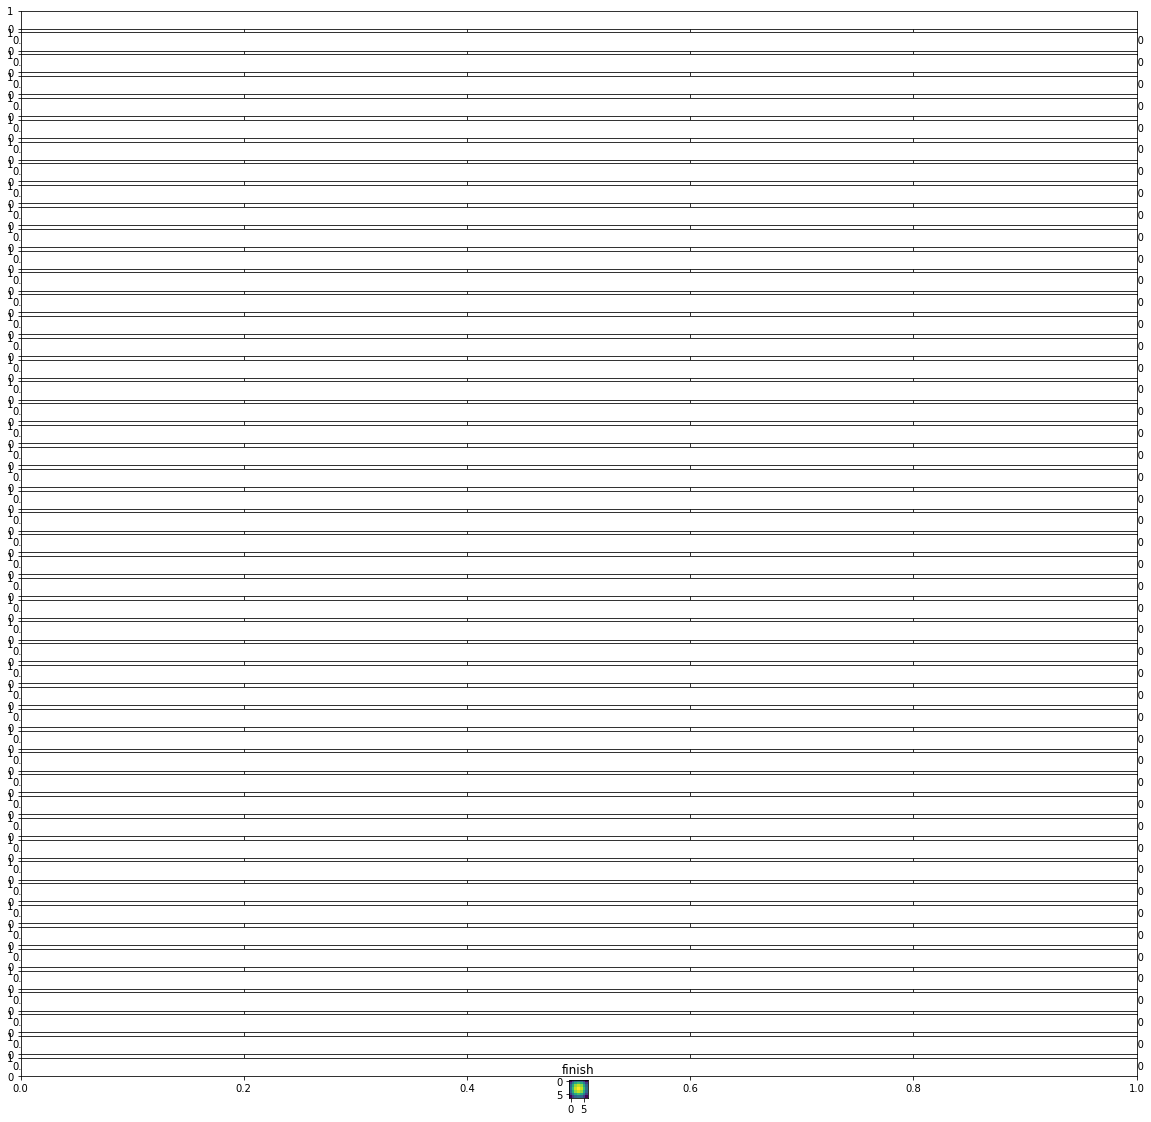

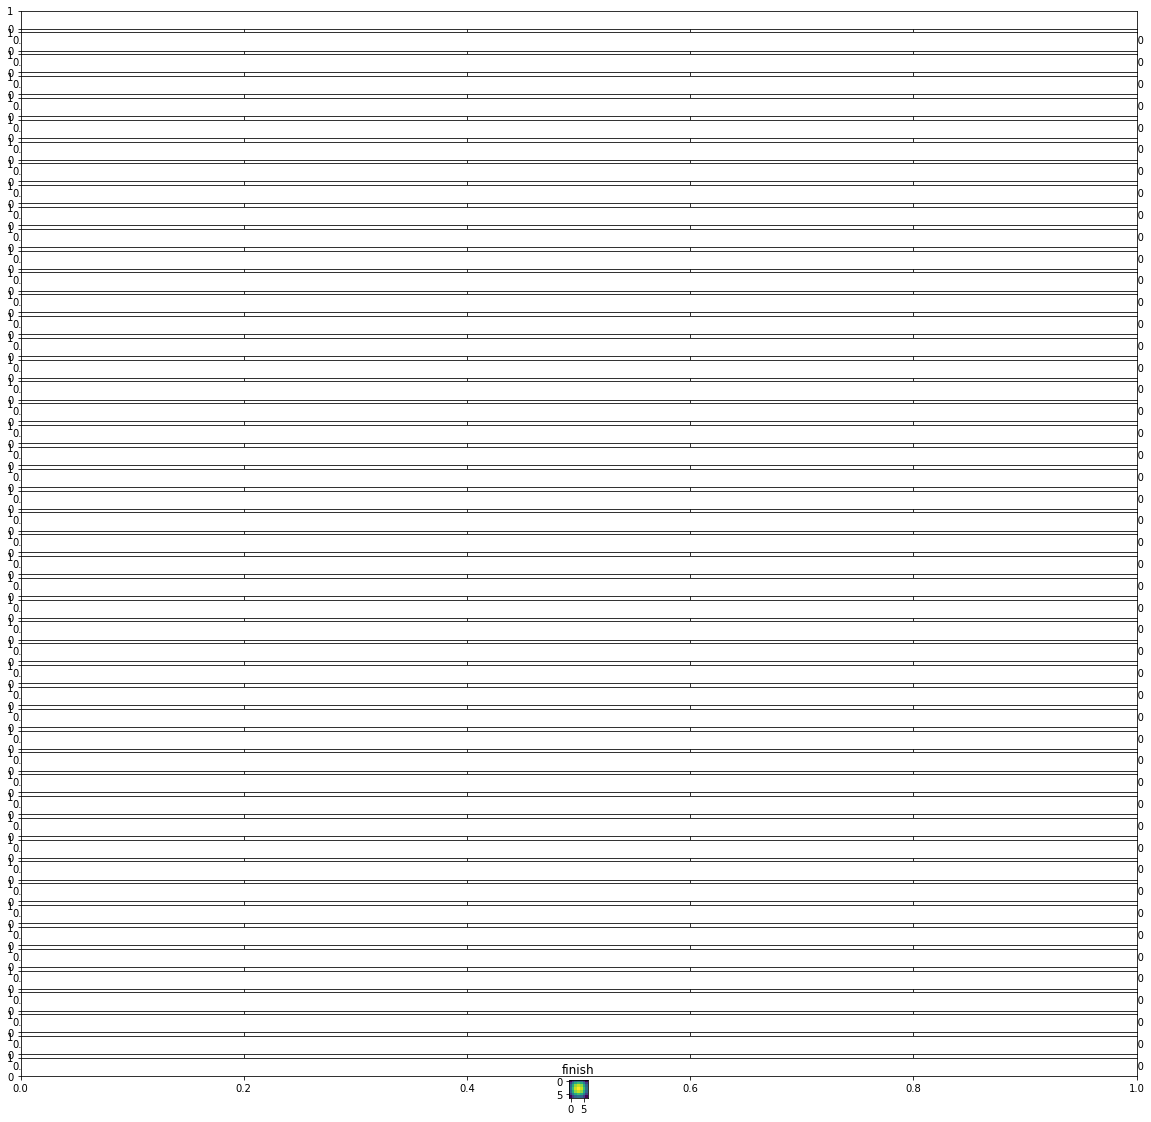

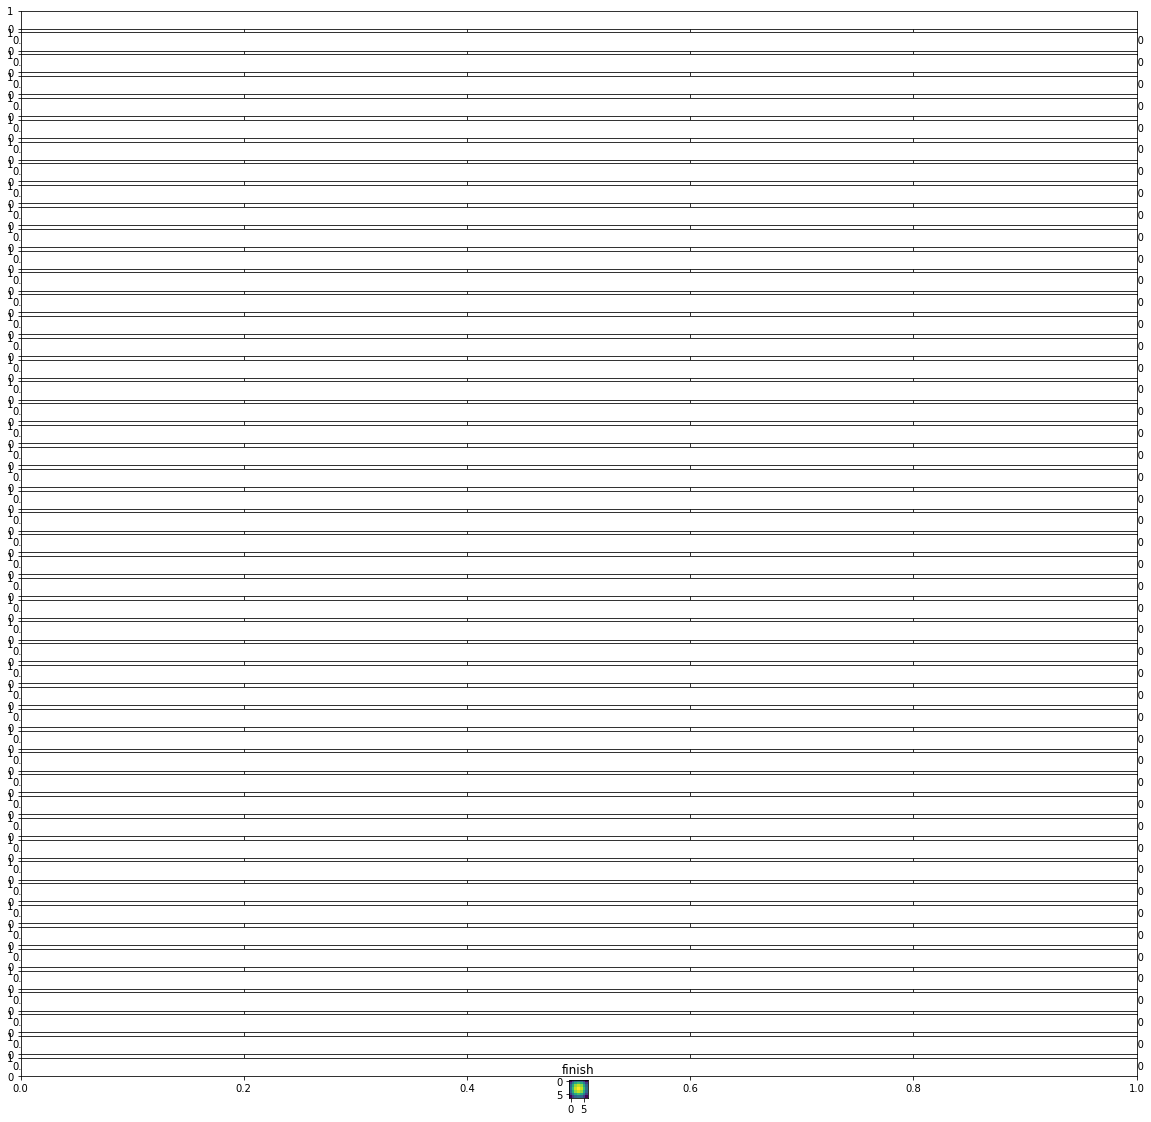

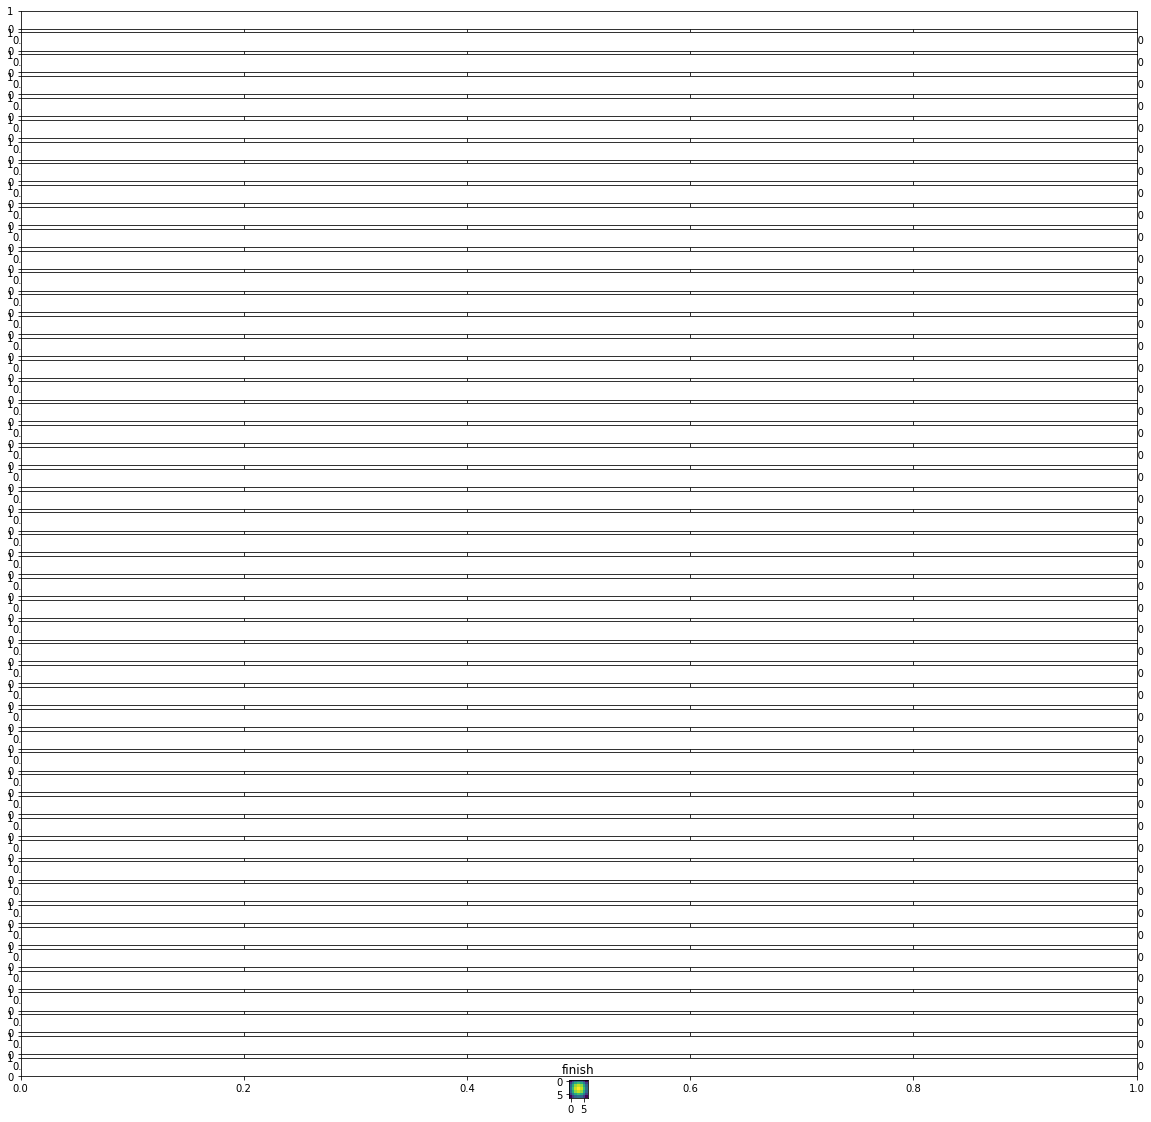

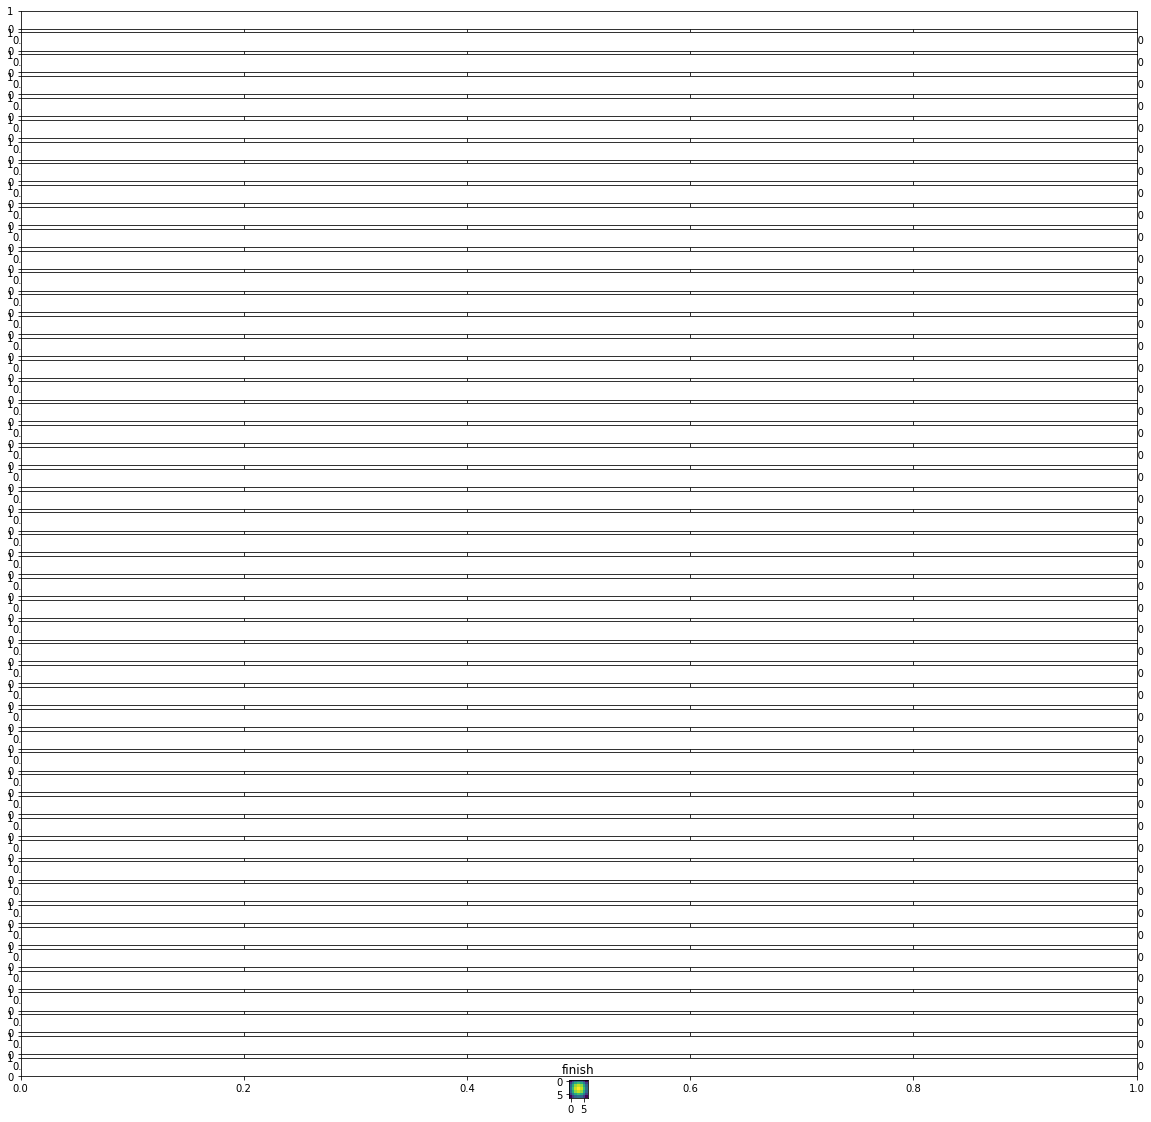

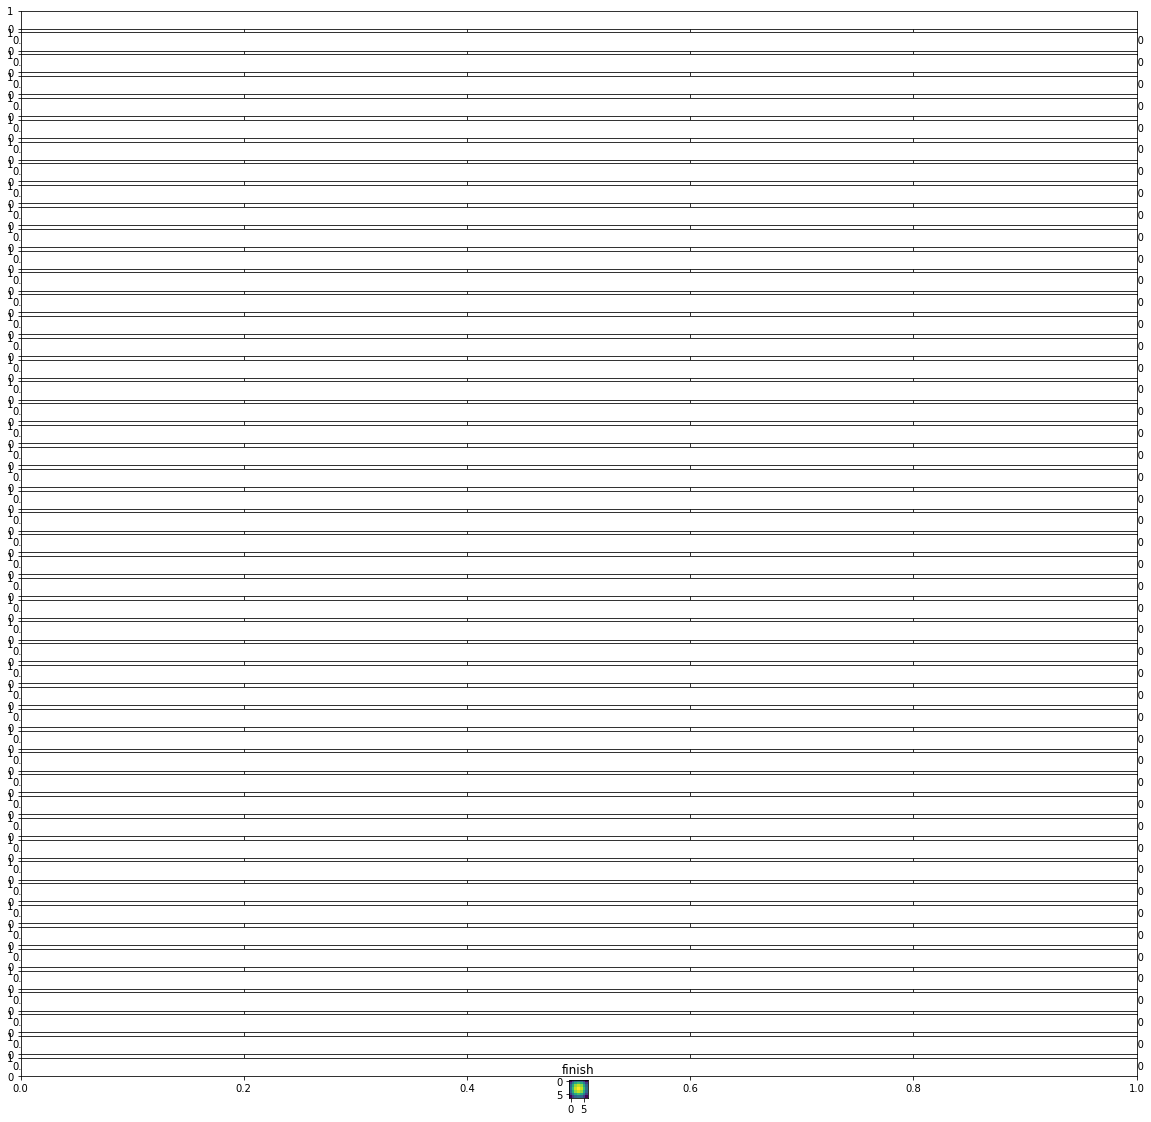

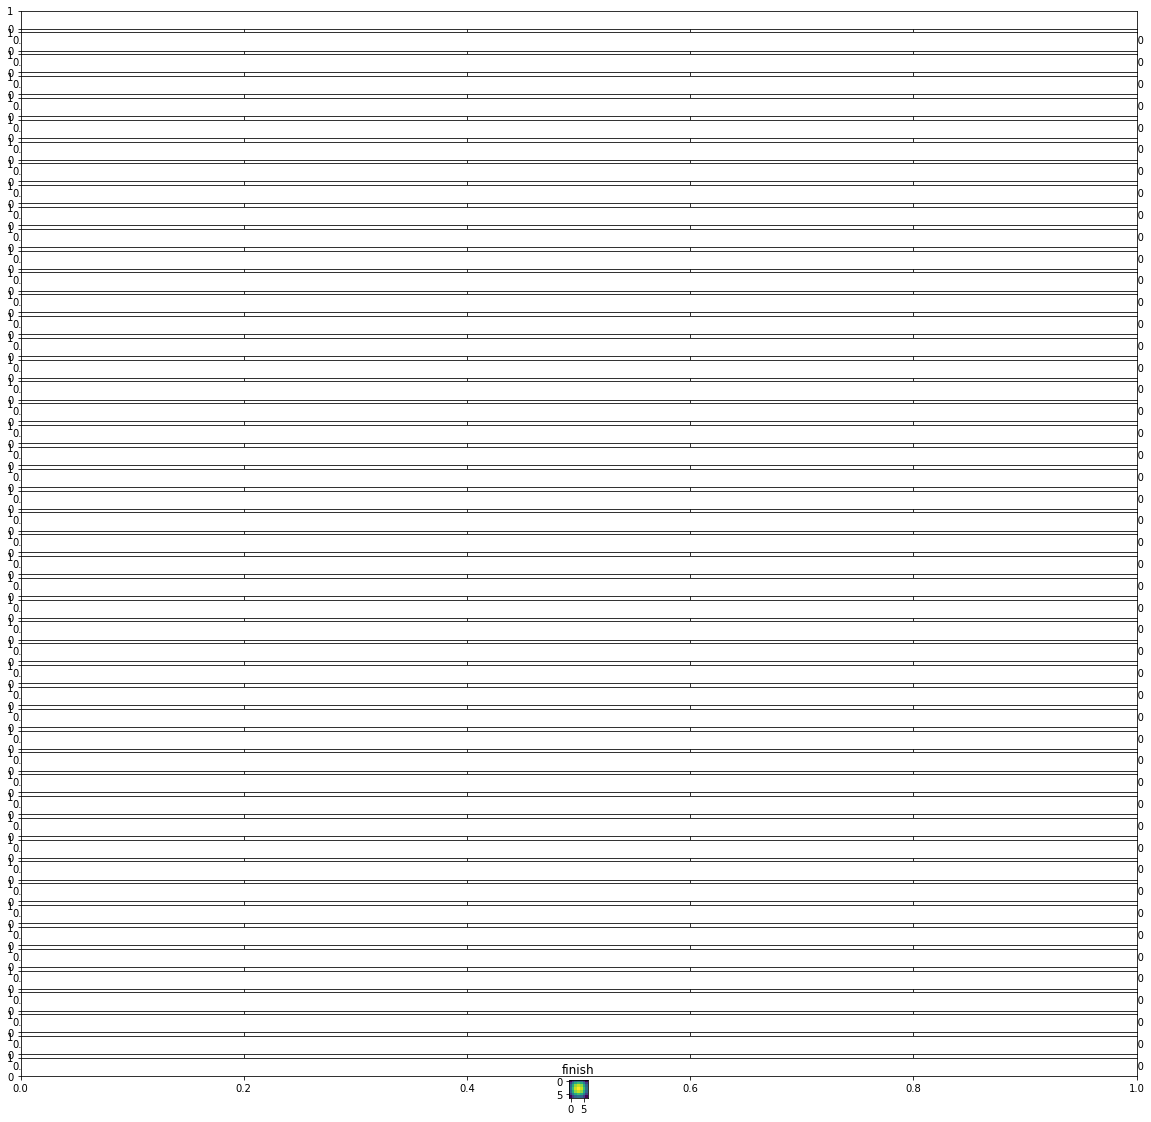

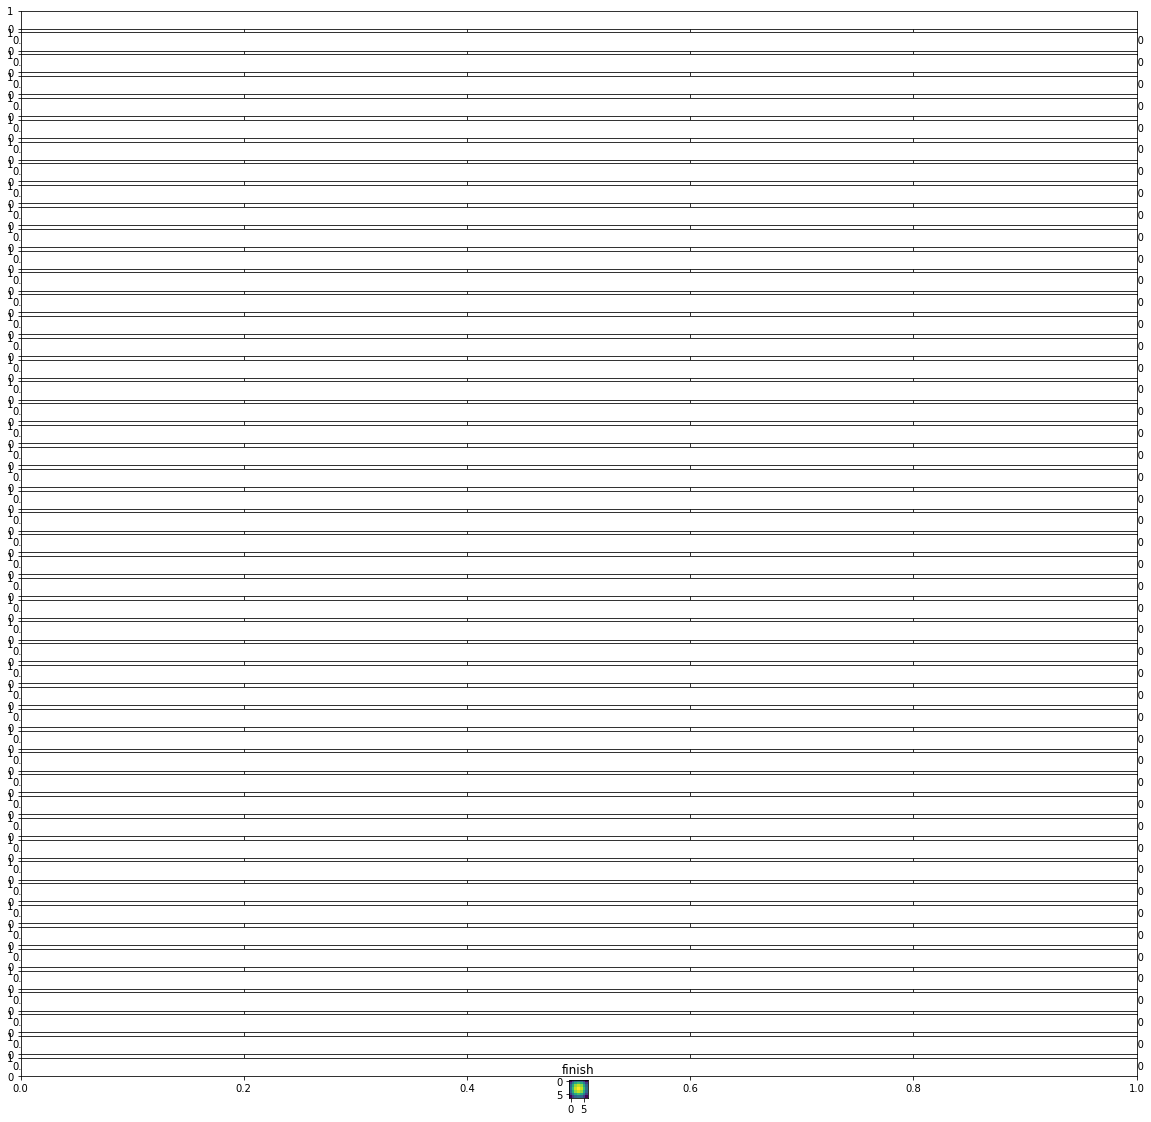

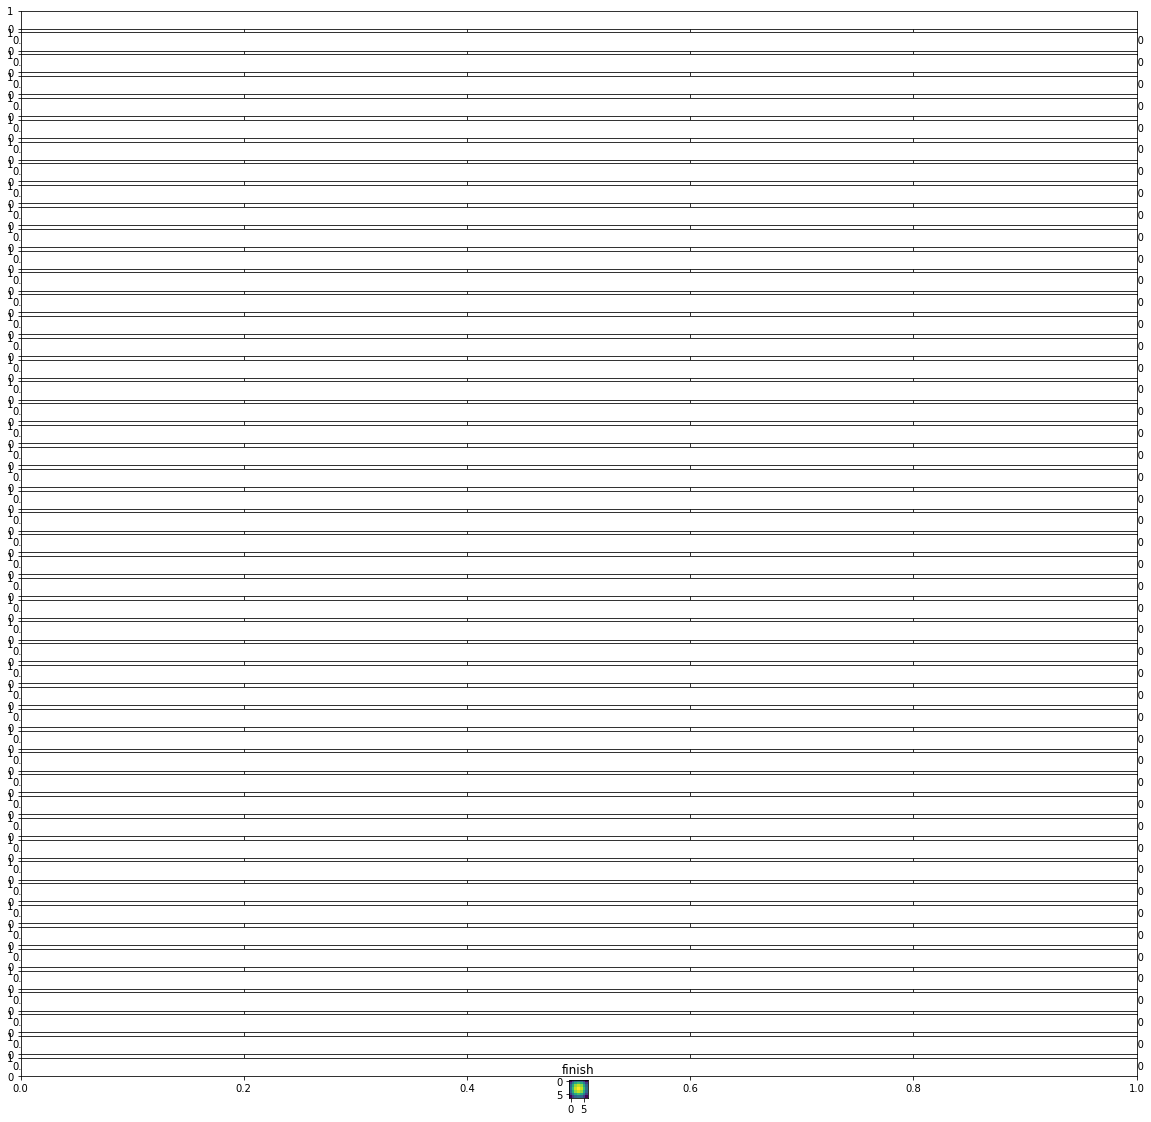

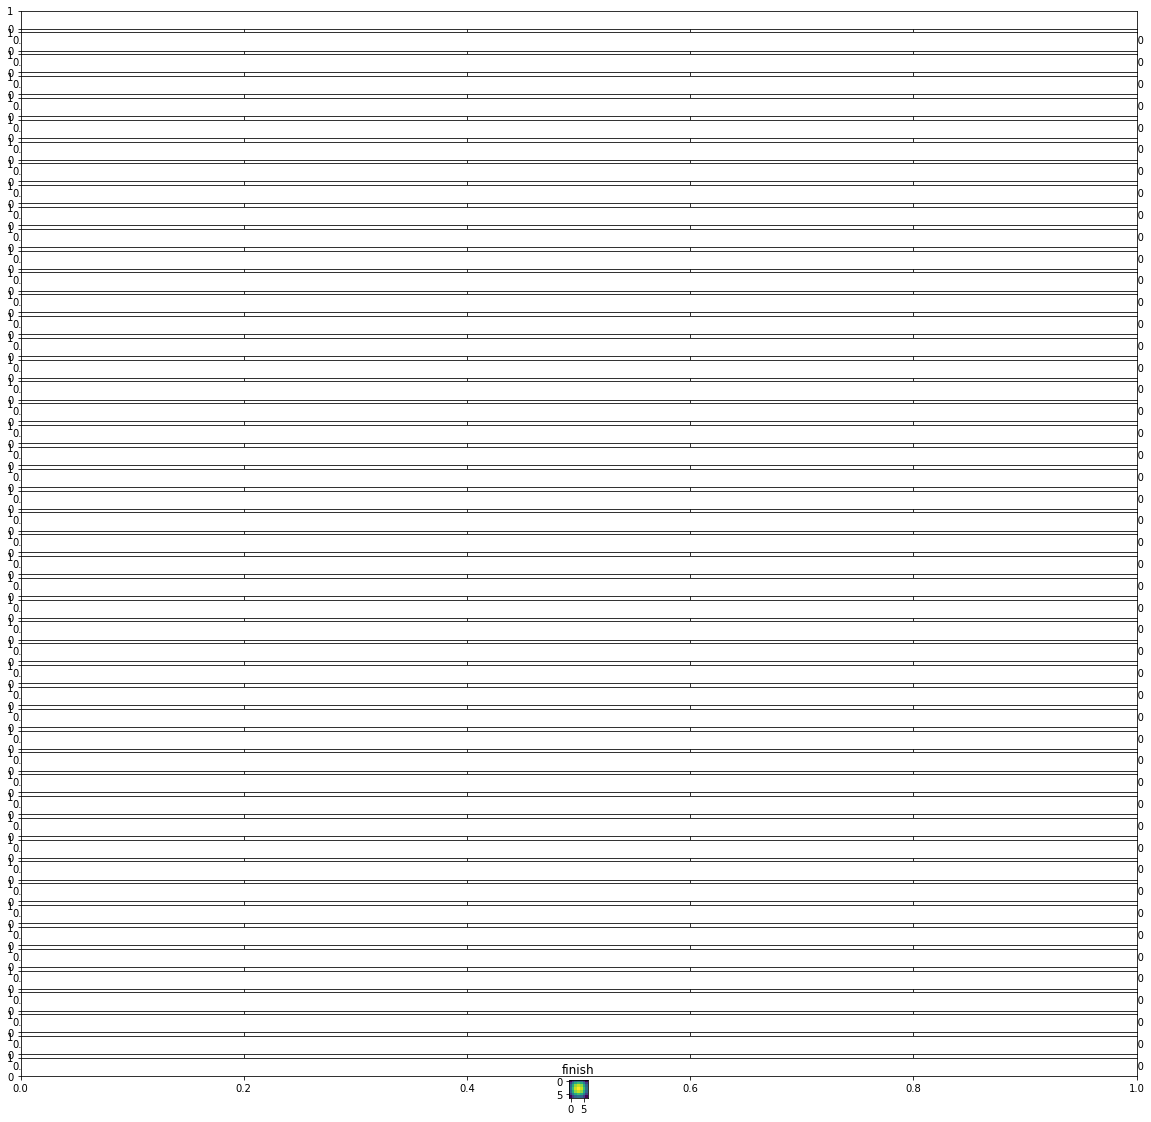

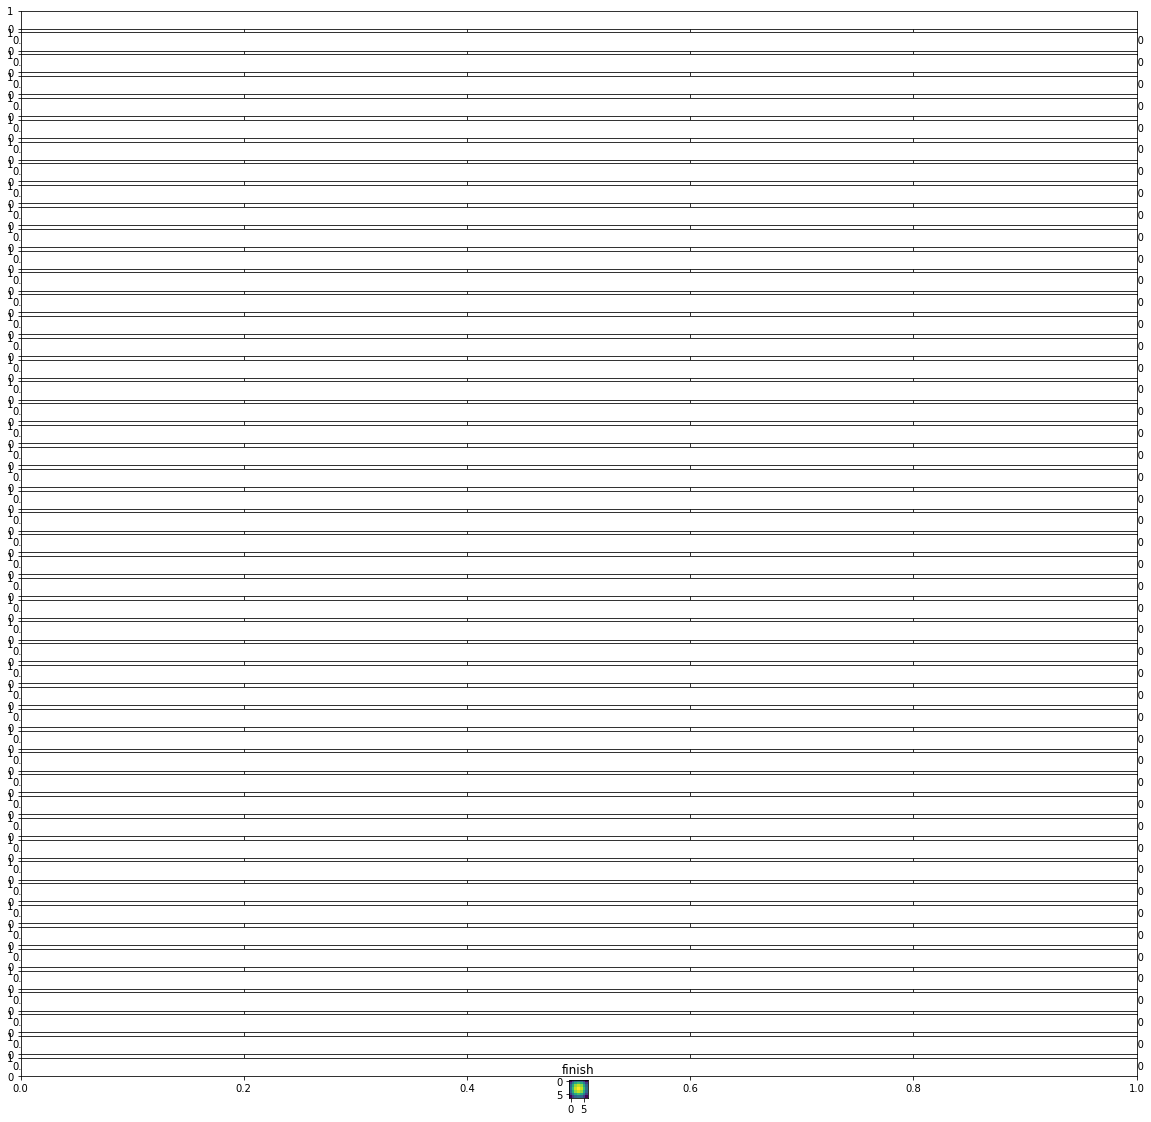

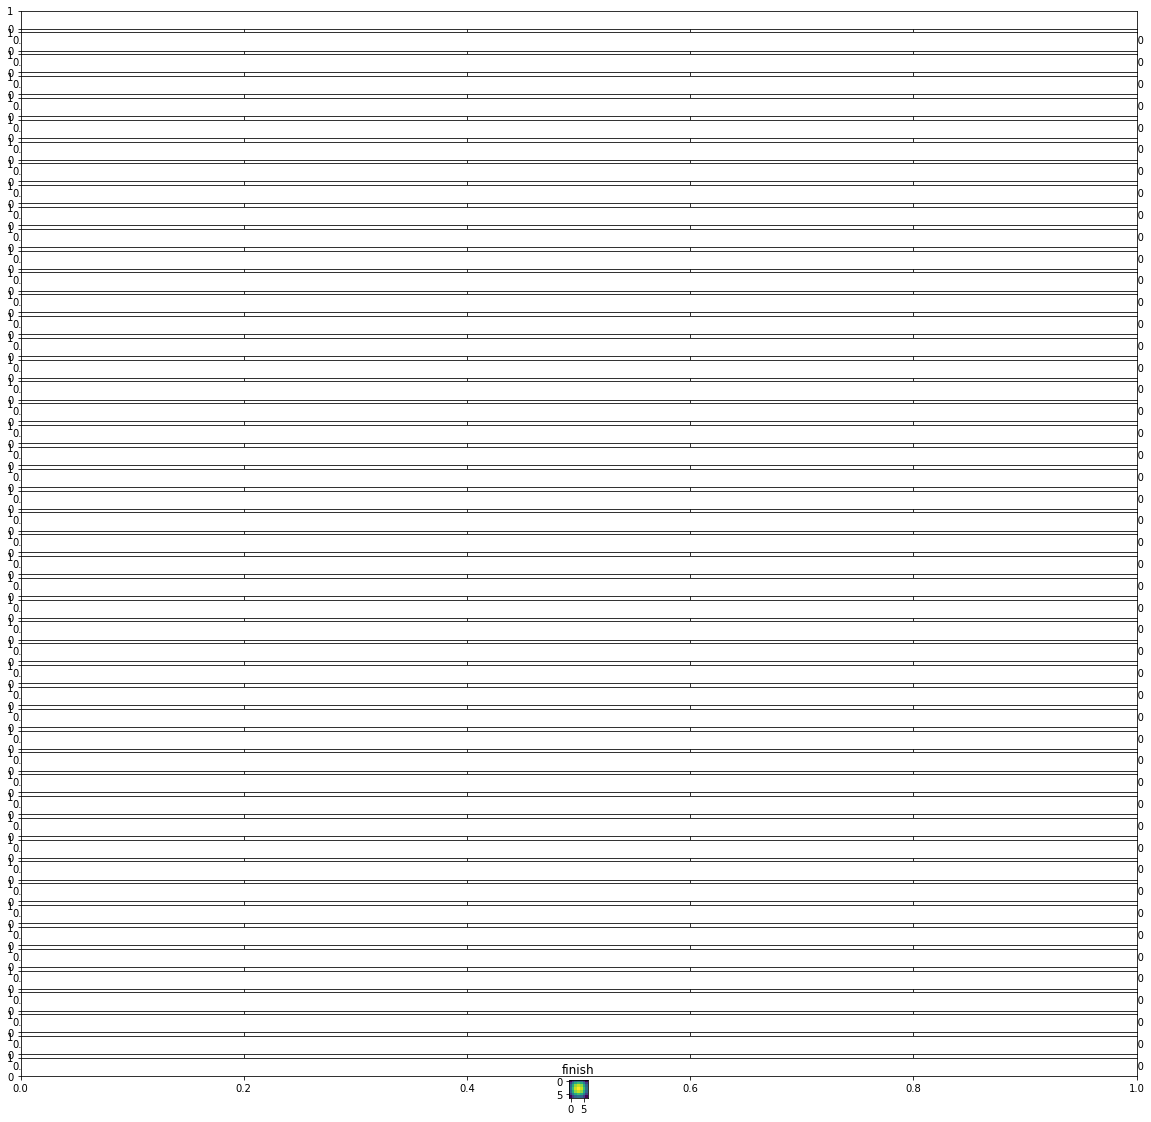

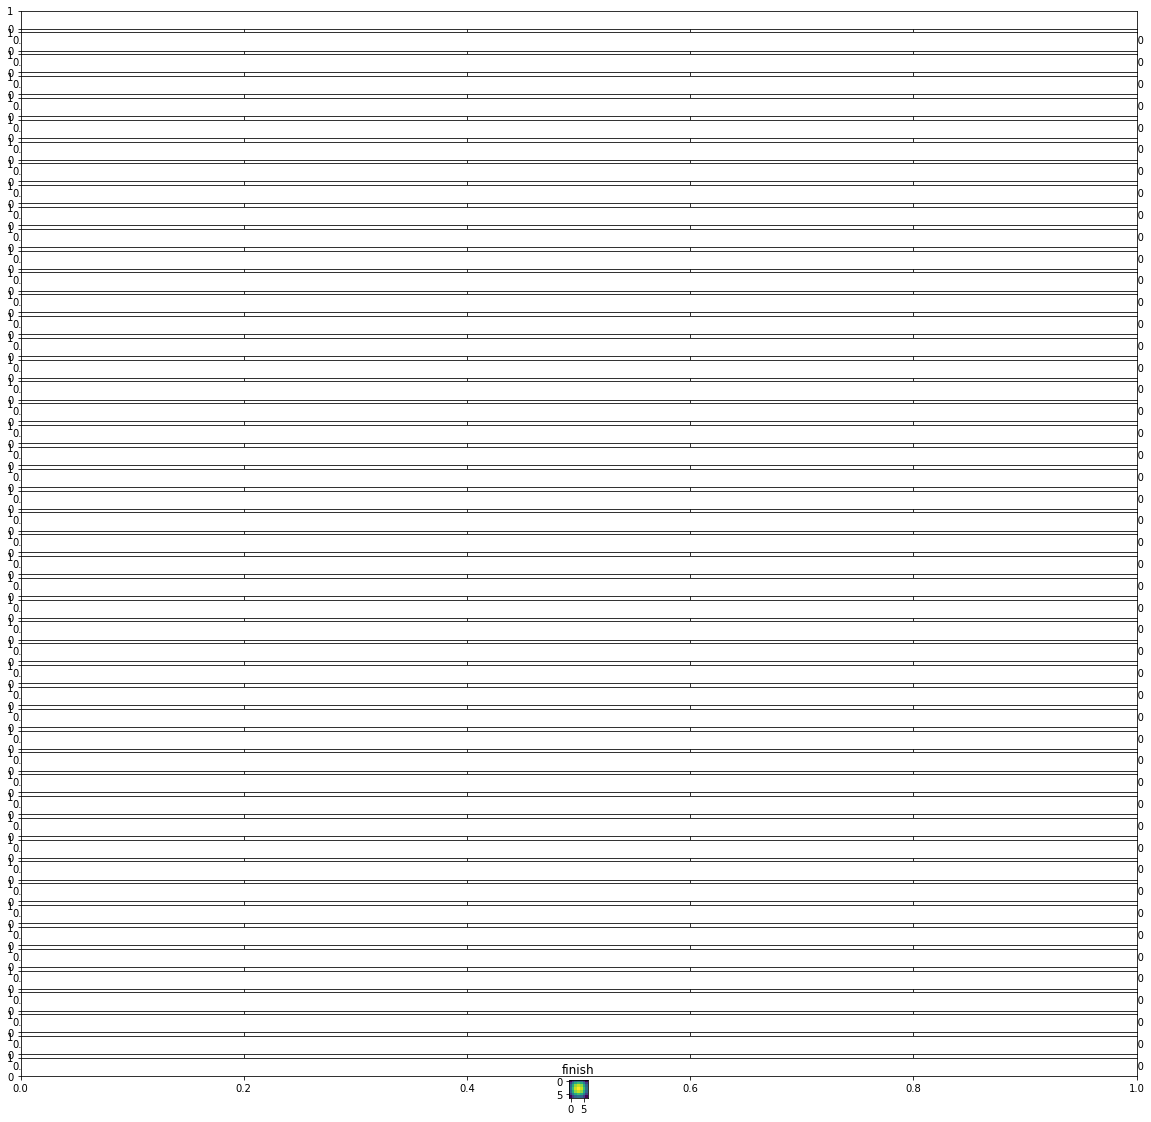

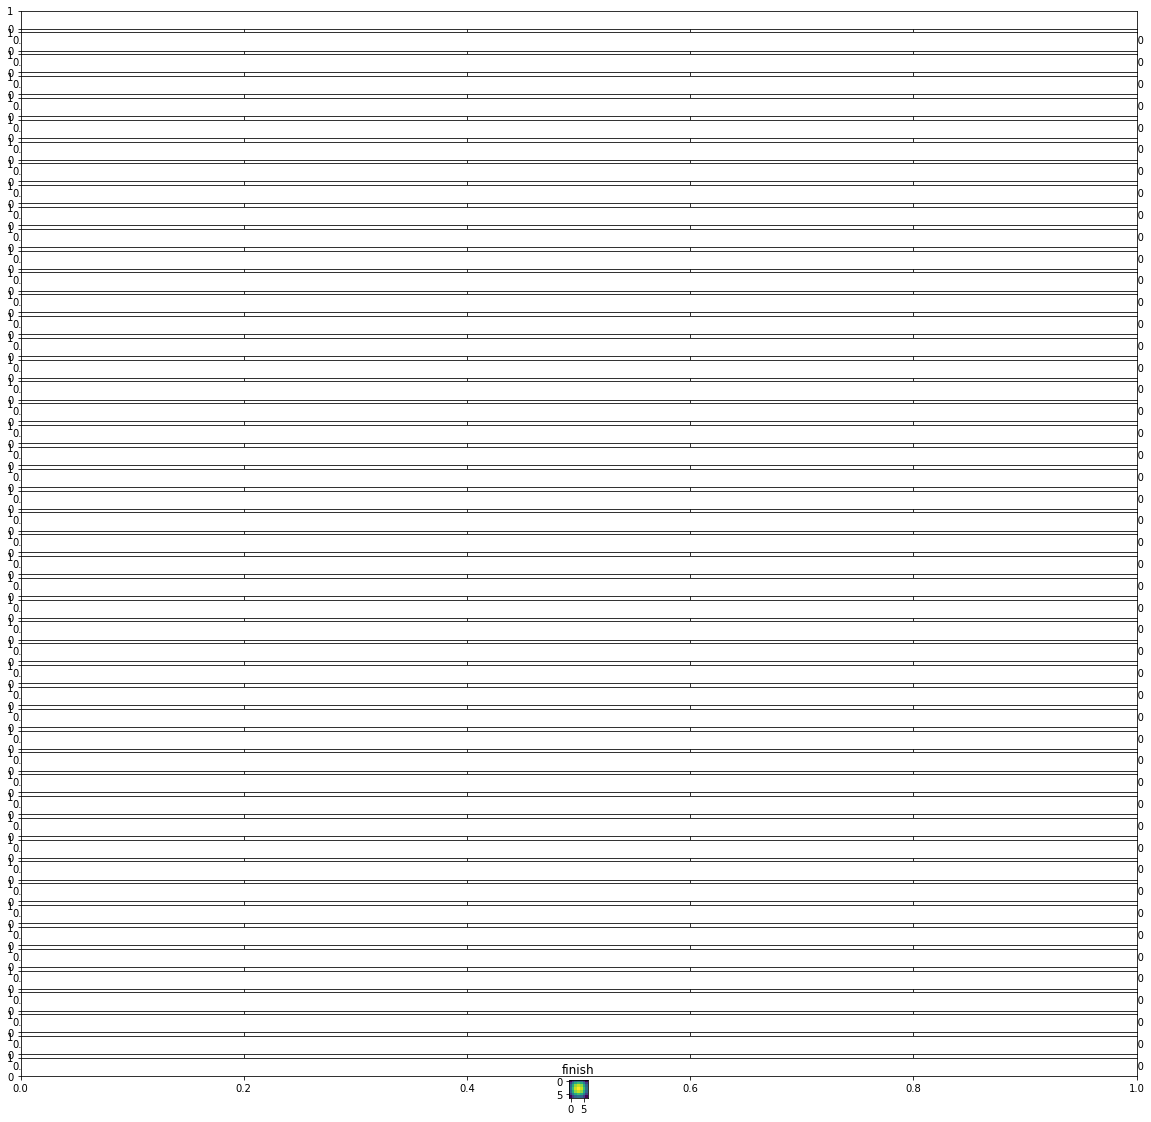

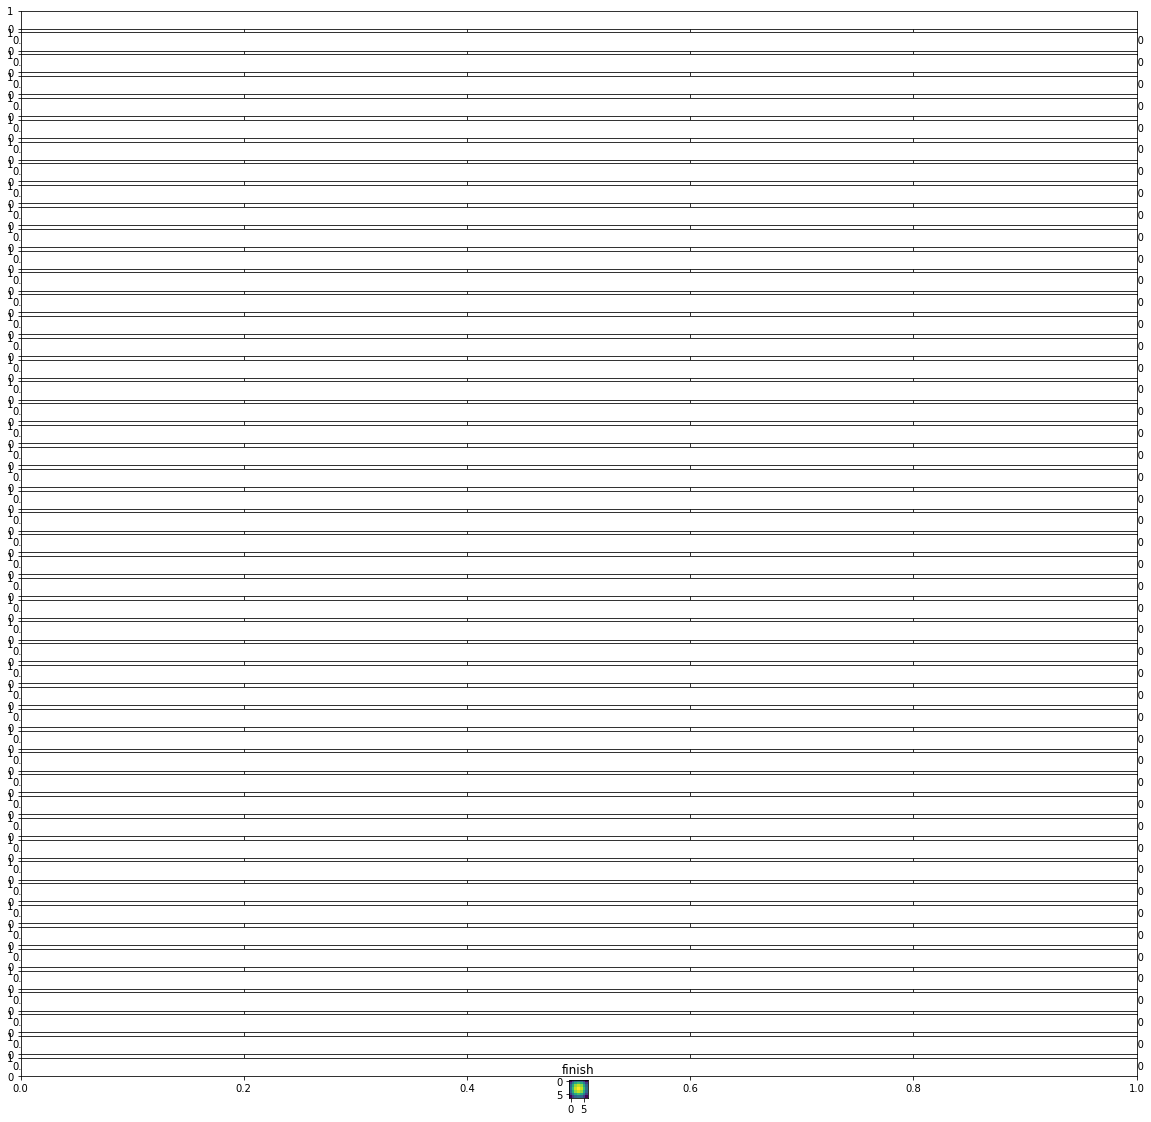

In [18]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
shape = [batch_size, image_size, image_size, num_channels]

# Construct a 7-layer CNN.
# C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# S2: sub-sampling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# S4: sub-sampling layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# F6: fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10

graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
               initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
               initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
               initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
    s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
    s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')

    # Model.
    def model(data, keep_prob, shape):
        LCN = LecunLCN(data, shape)
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')  # convolution layer
        hidden = tf.nn.relu(conv + layer1_biases)  # relu if function y = max(0, x)
        lrn = tf.nn.lrn(hidden)  # local response normalization
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.lrn(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]
    
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9375, shape)

    loss = \
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=tf_train_labels[:,1])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=tf_train_labels[:,2])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=tf_train_labels[:,3])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=tf_train_labels[:,4])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=tf_train_labels[:,5]))

    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.stack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
    valid_prediction = tf.stack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
    test_prediction = tf.stack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  
#     reader = tf.train.NewCheckpointReader("./model/CNN_1.ckpt")
#     reader.get_variable_to_shape_map()
#     print("Model restored.")  
    
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict
        )
    
        if (step % 10000 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,1:6]))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, "./model/CNN_multi.ckpt")
    print("Model saved in file: %s" % save_path)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/CNN_multi.ckpt
Model restored.
Initialized
Minibatch loss at step 0: nan
Minibatch accuracy: 11.9%
Validation accuracy: 5.2%
Minibatch loss at step 10000: nan
Minibatch accuracy: 8.4%
Validation accuracy: 5.2%
Minibatch loss at step 20000: nan
Minibatch accuracy: 10.3%
Validation accuracy: 5.2%
Minibatch loss at step 30000: nan
Minibatch accuracy: 10.6%
Validation accuracy: 5.2%
Minibatch loss at step 40000: nan
Minibatch accuracy: 9.4%
Validation accuracy: 5.2%
Minibatch loss at step 50000: nan
Minibatch accuracy: 5.9%
Validation accuracy: 5.2%
Minibatch loss at step 60000: nan
Minibatch accuracy: 9.7%
Validation accuracy: 5.2%
Minibatch loss at step 70000: nan
Minibatch accuracy: 7.8%
Validation accuracy: 5.2%
Minibatch loss at step 80000: nan
Minibatch accuracy: 11.9%
Validation accuracy: 5.2%
Minibatch loss at step 90000: nan
Minibatch accuracy: 1

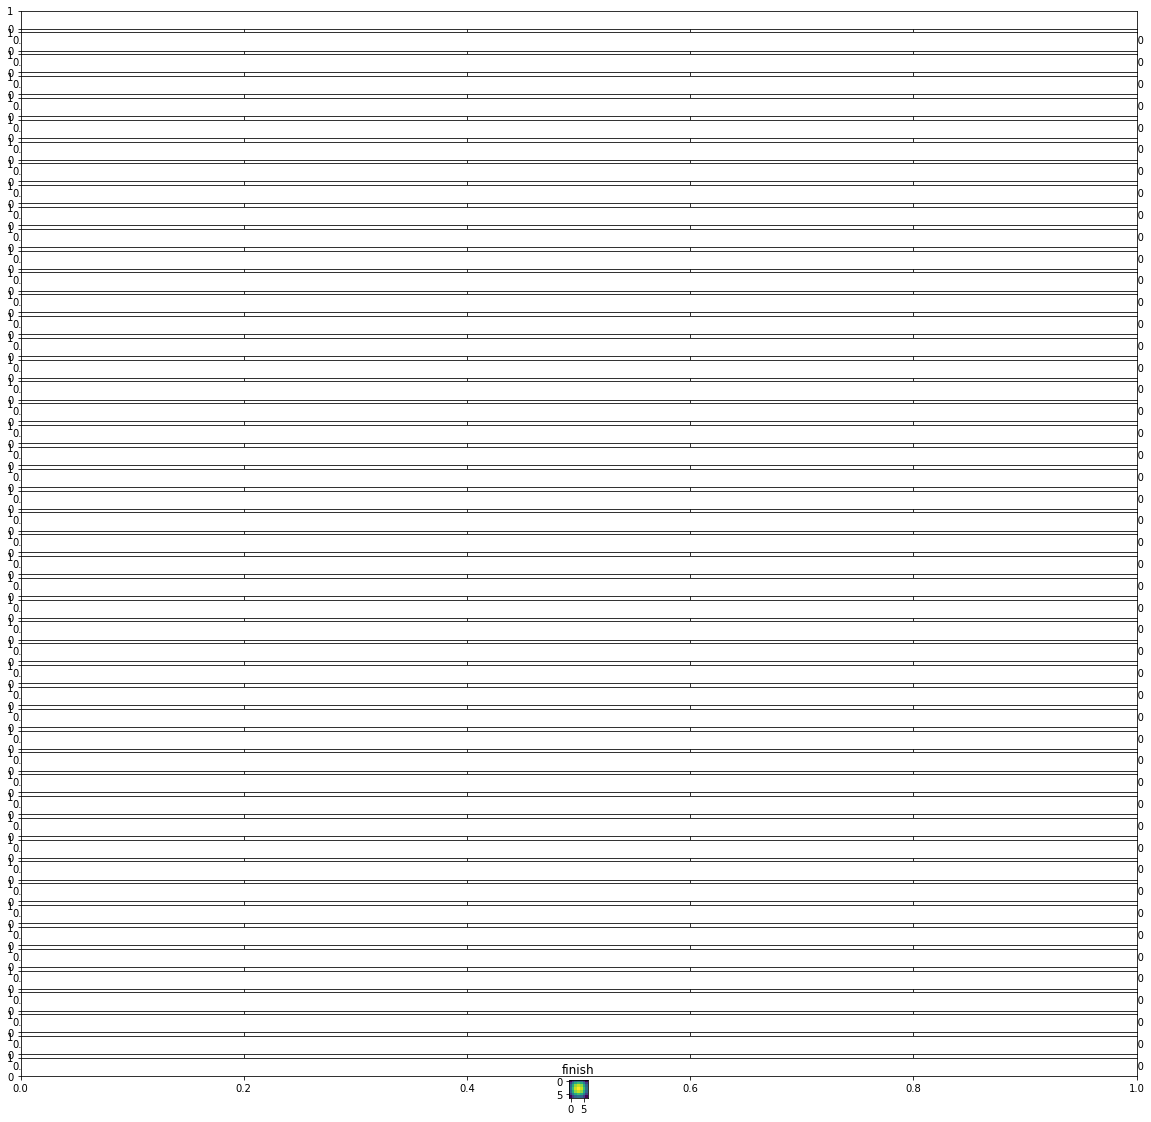

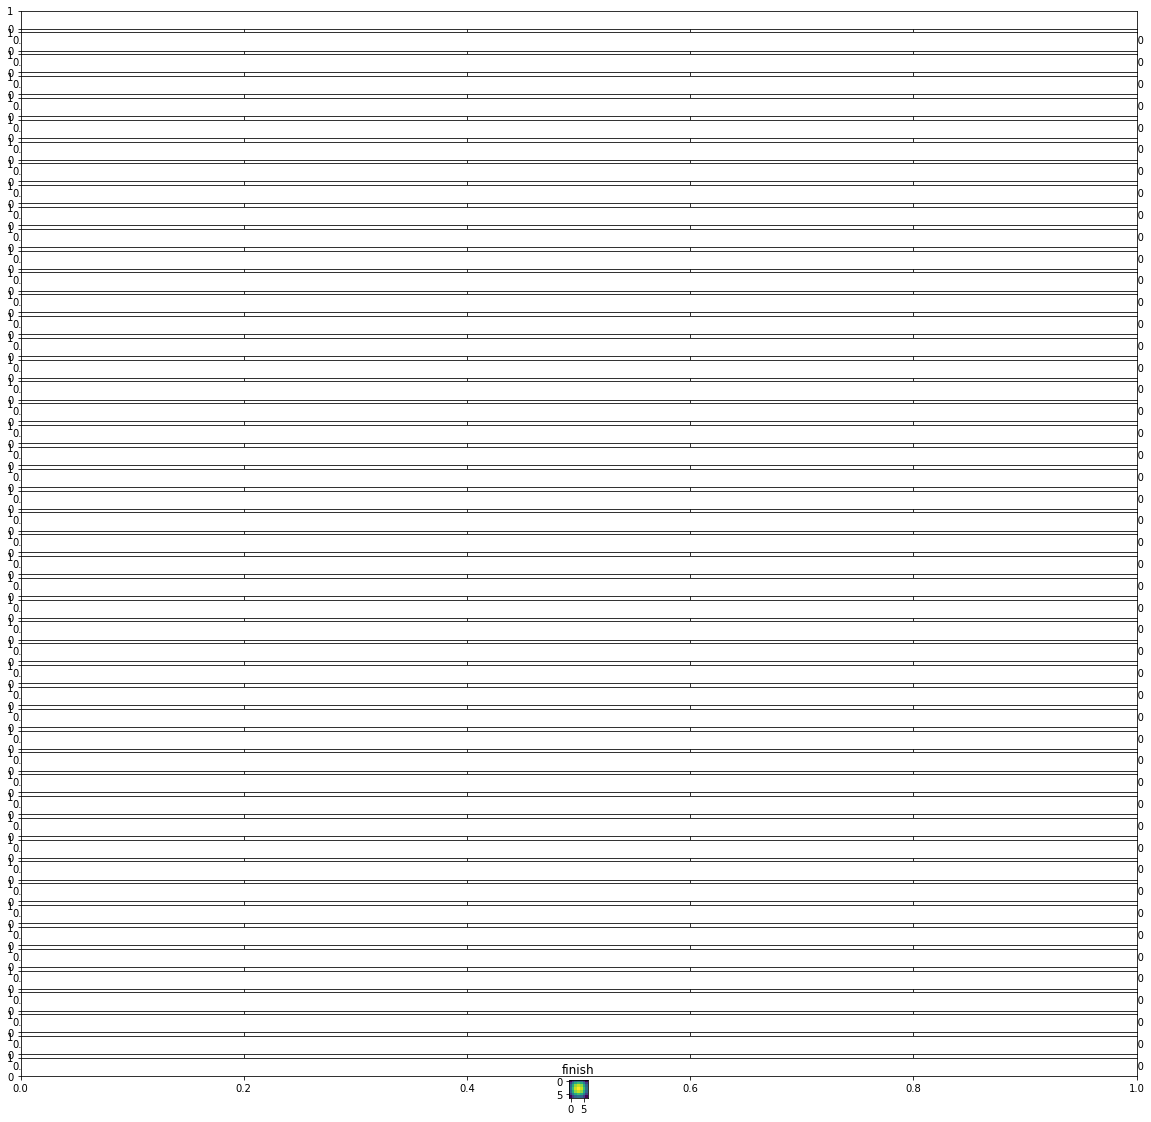

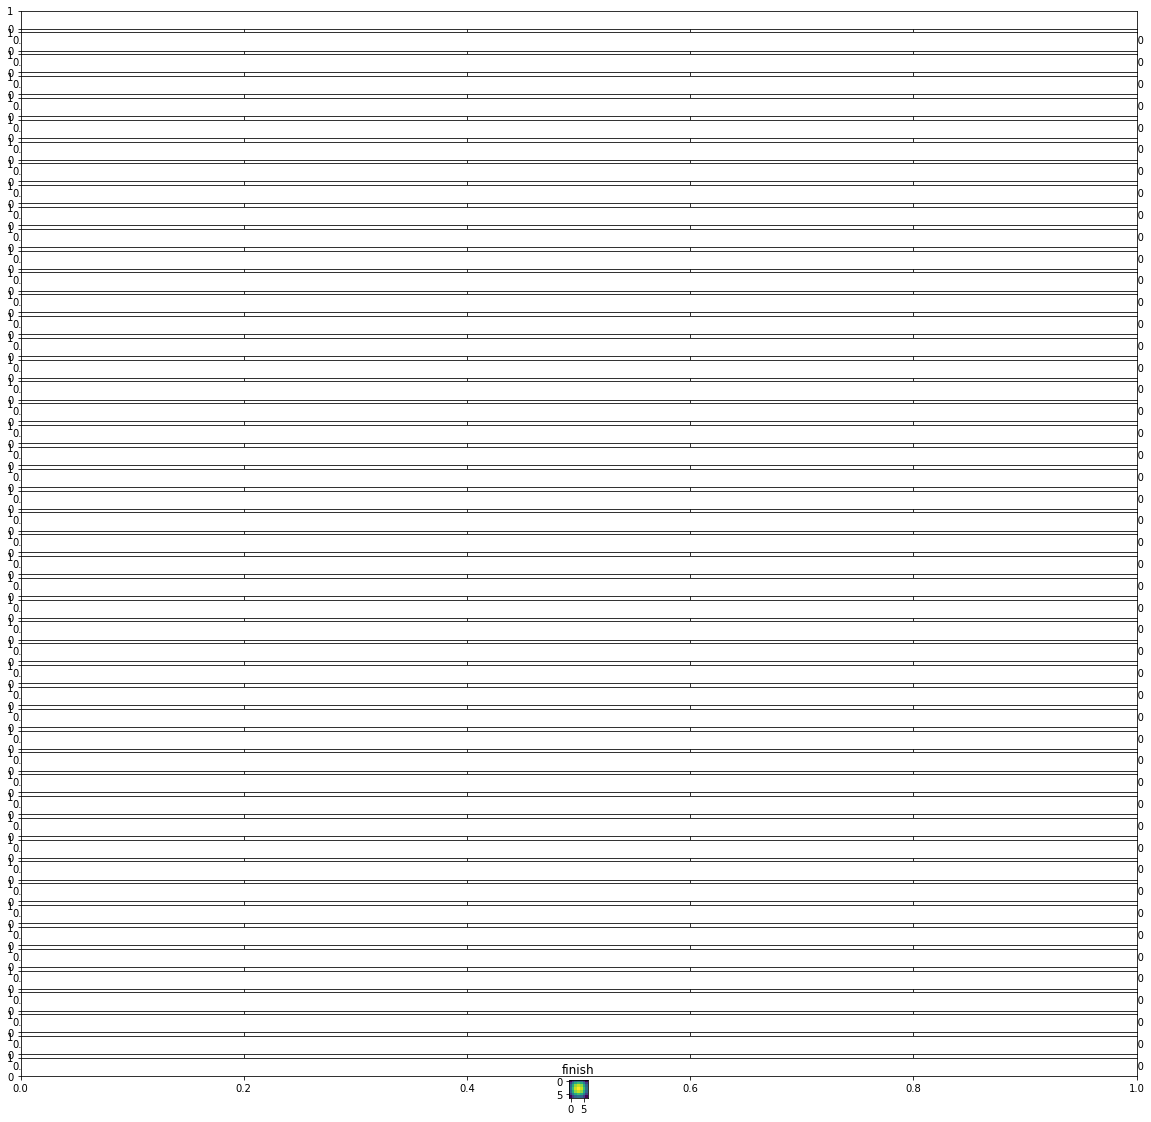

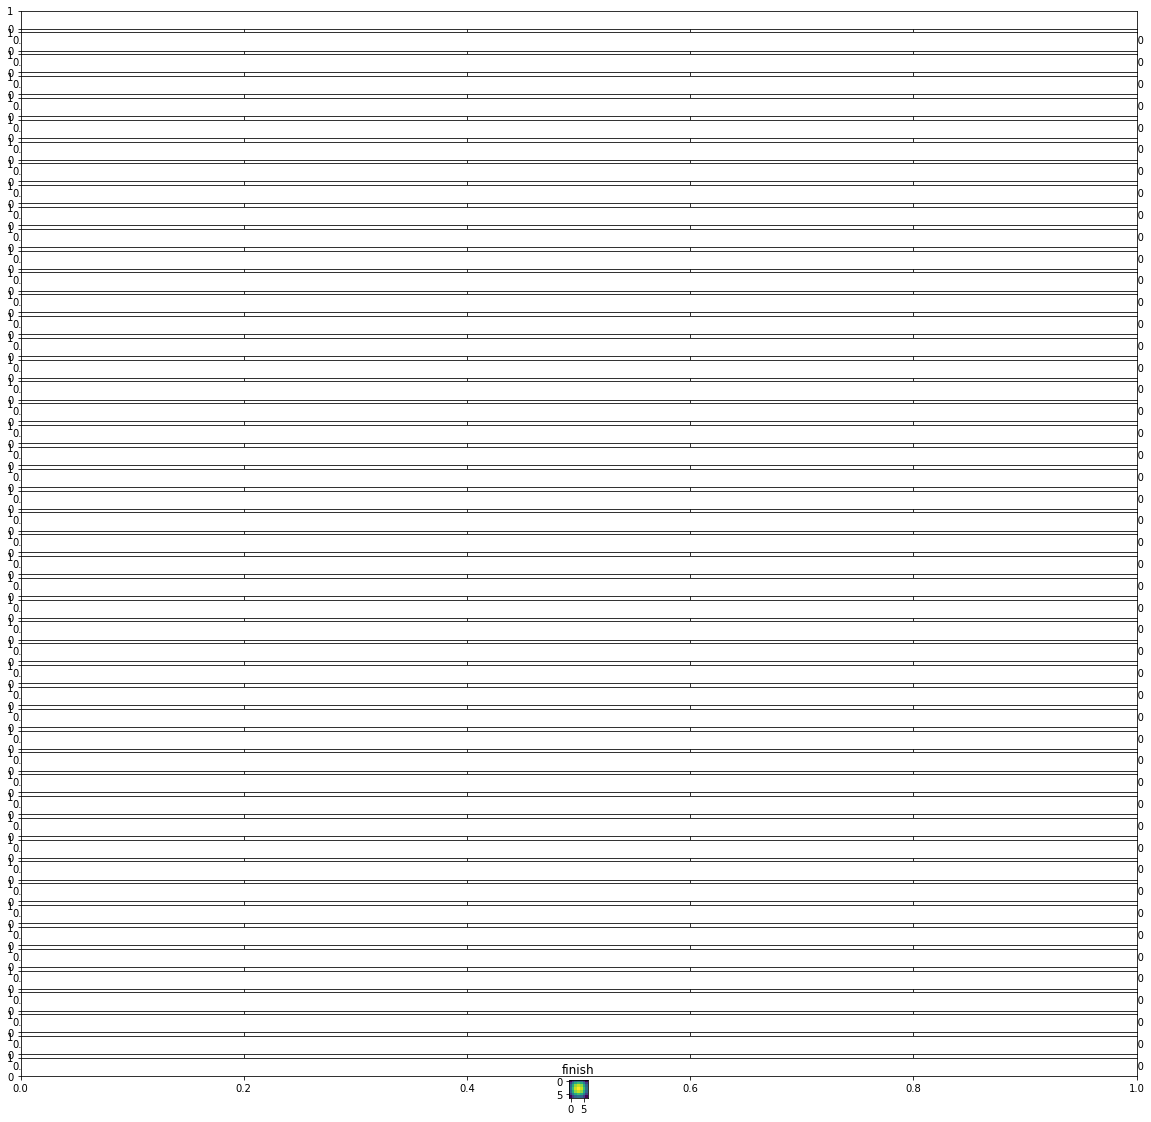

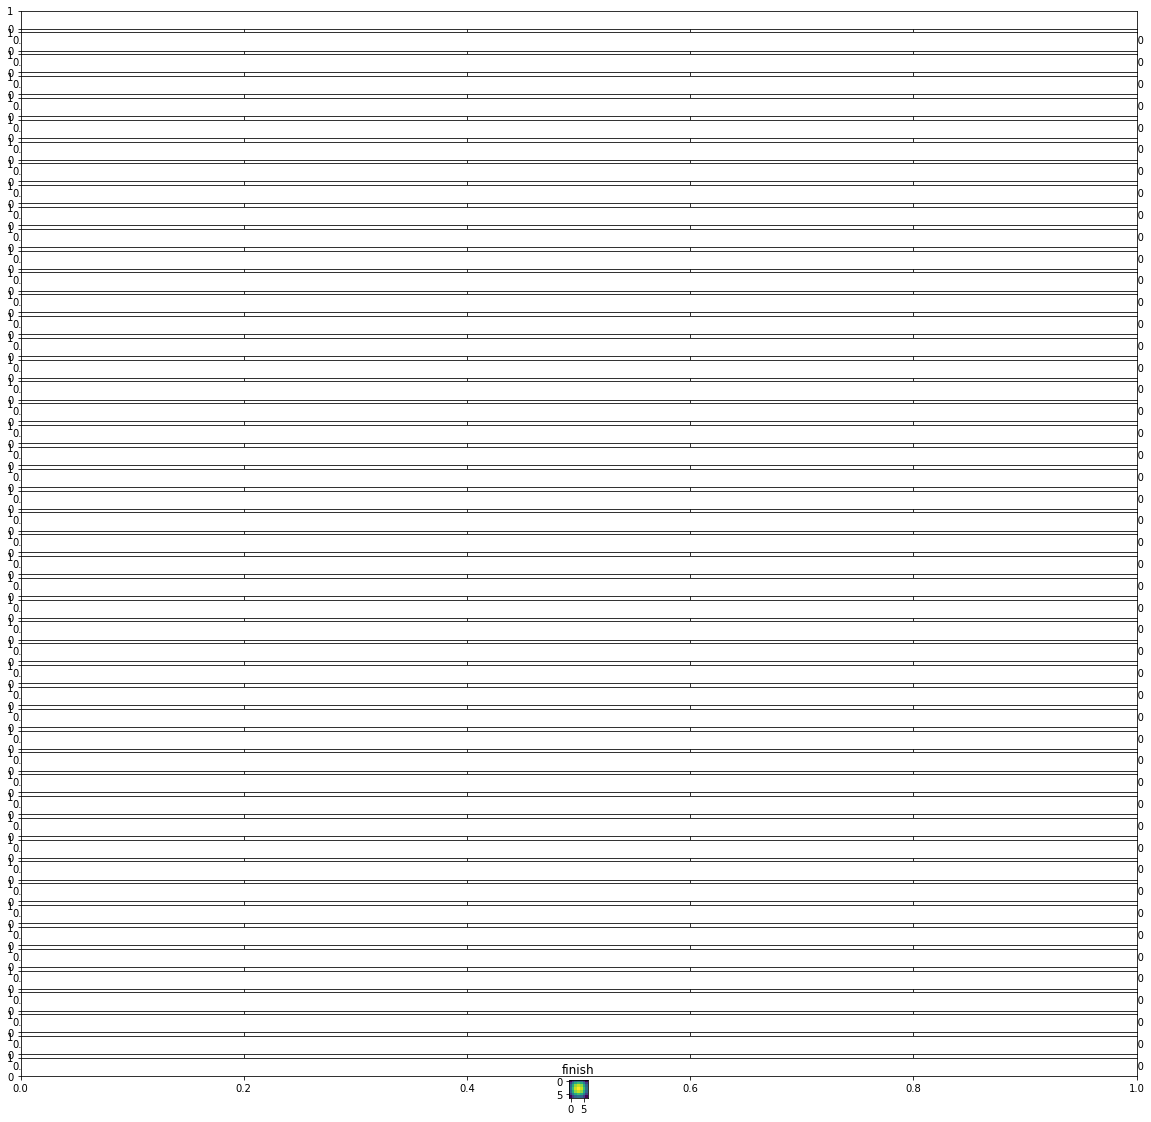

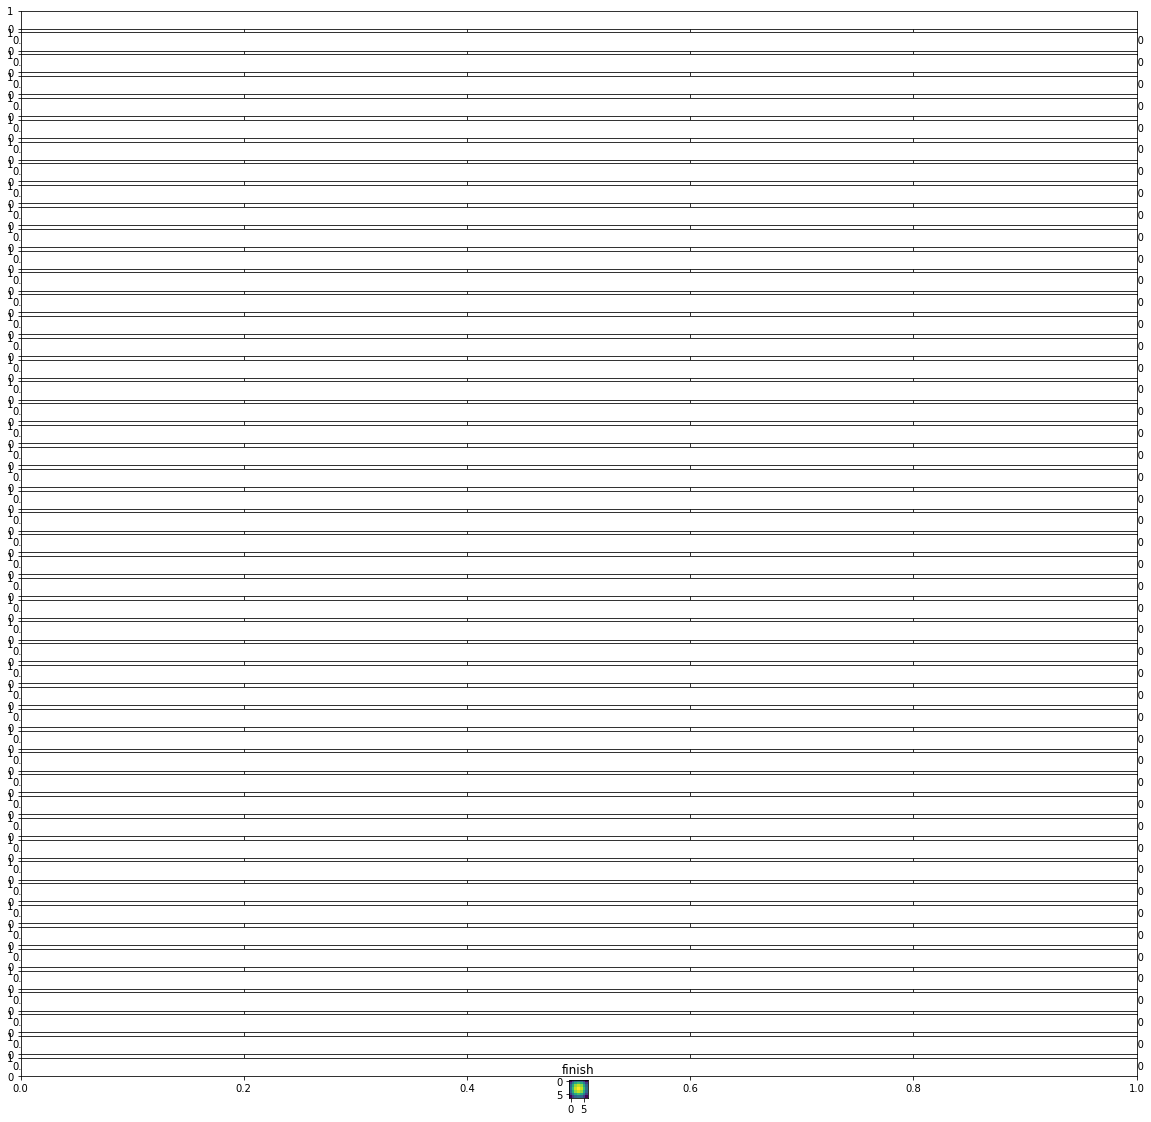

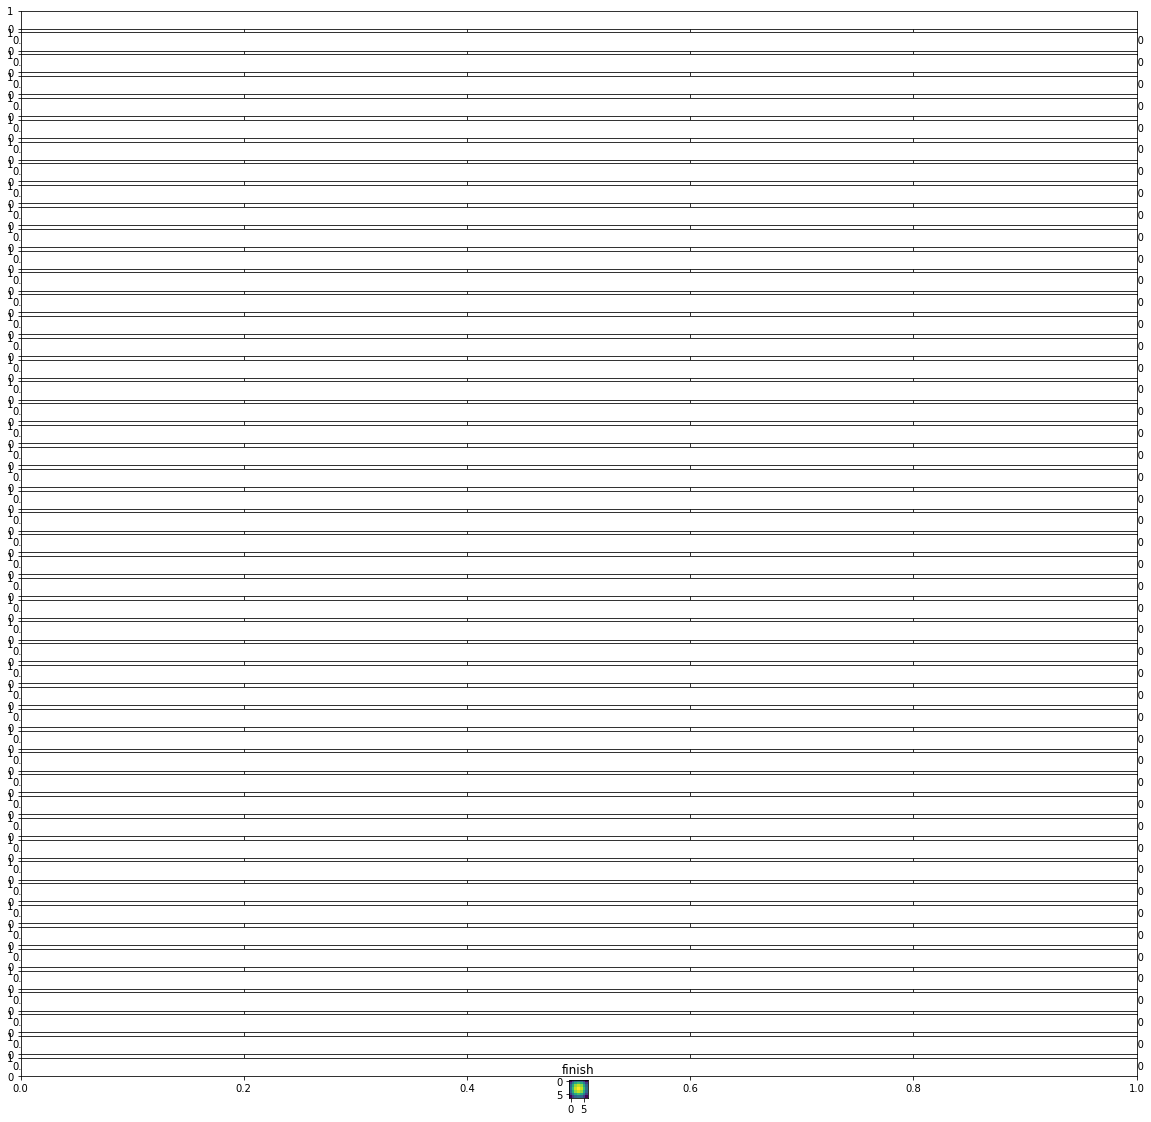

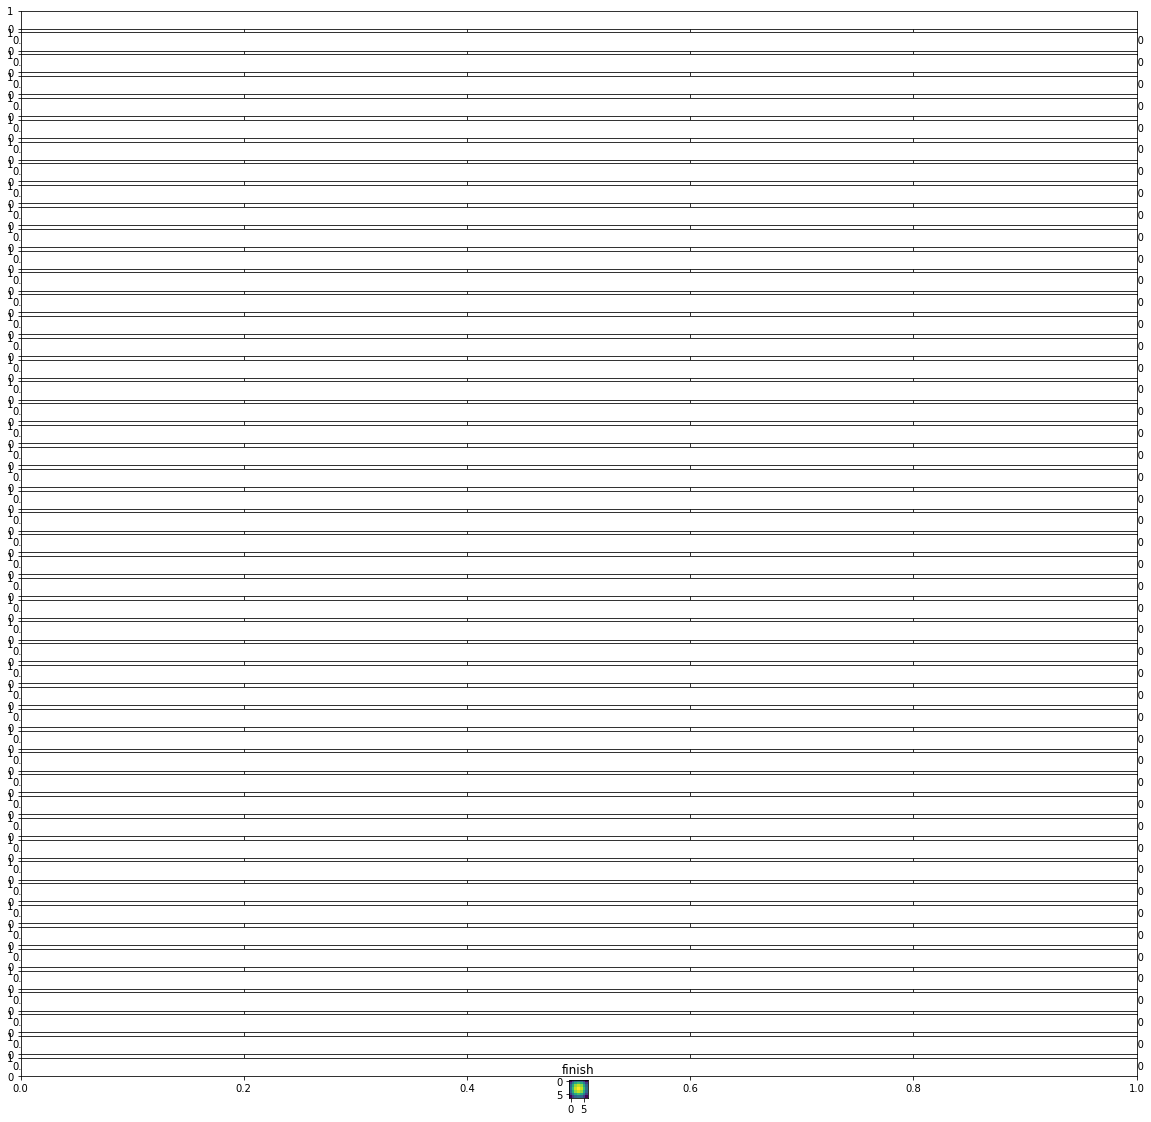

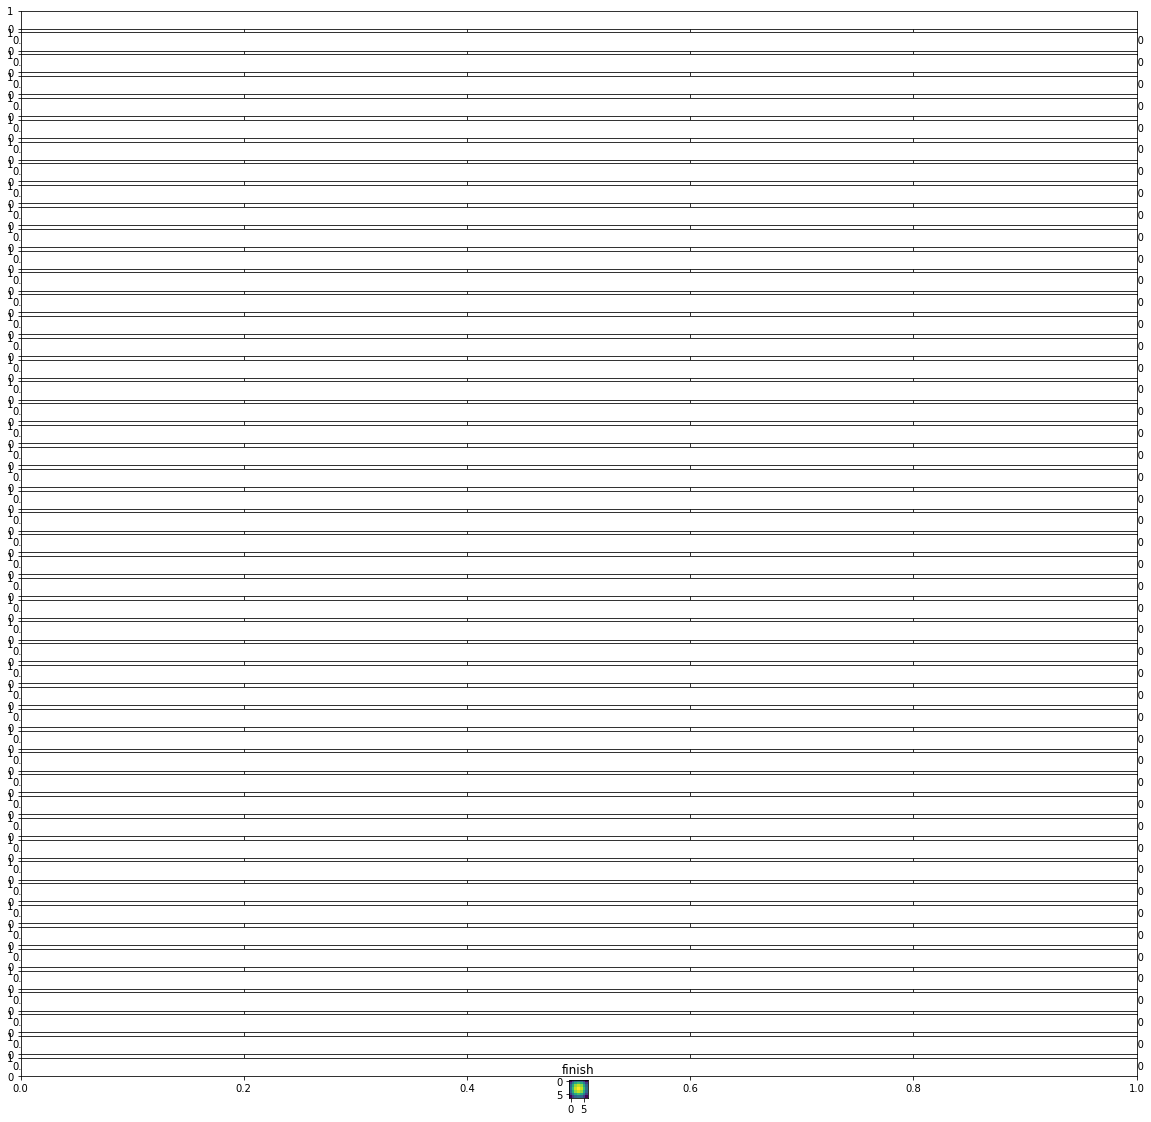

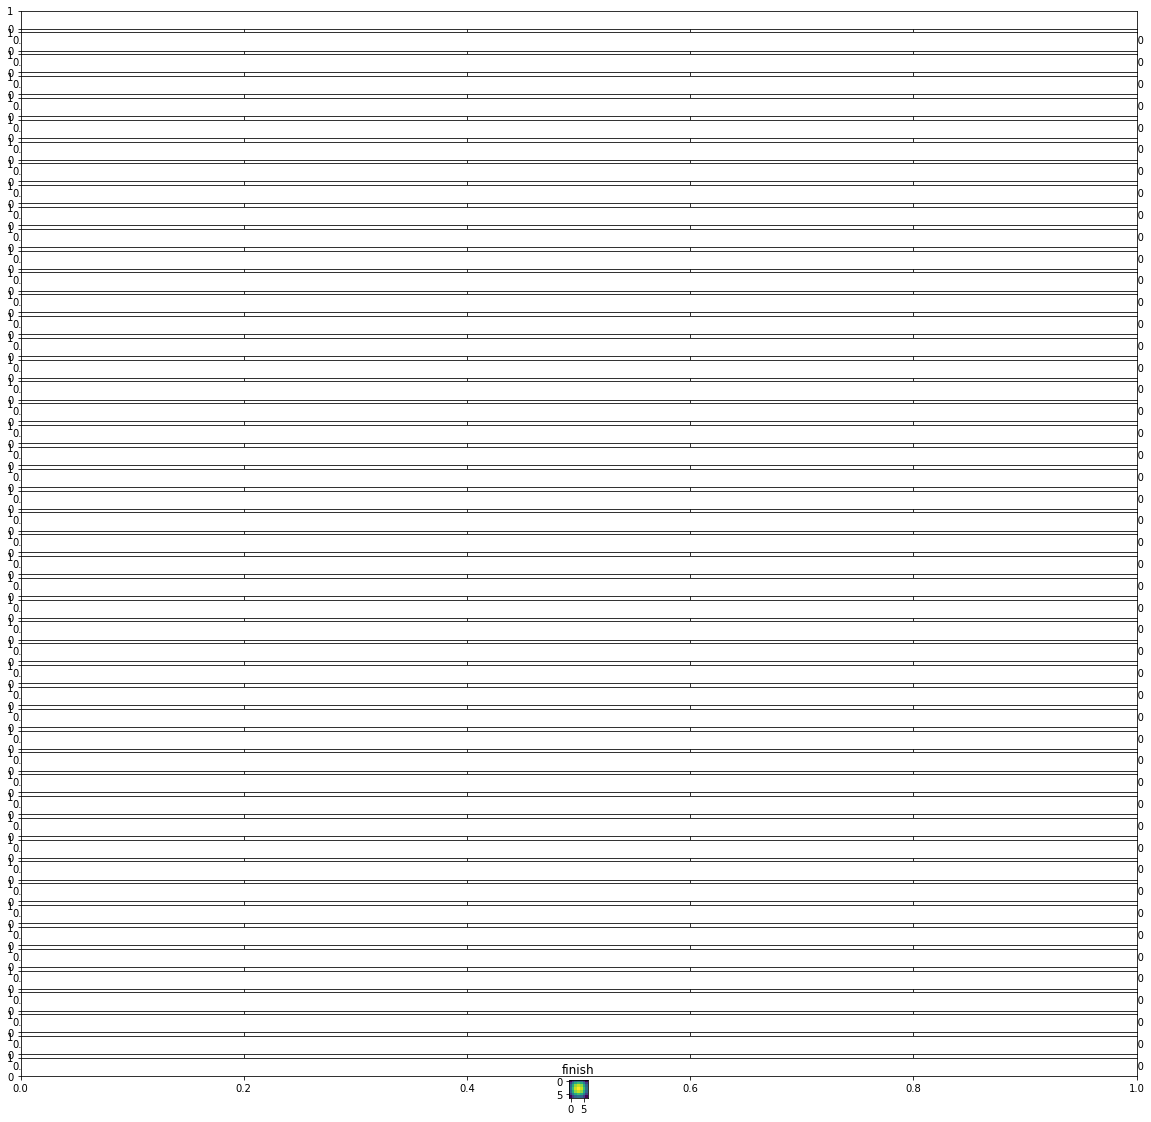

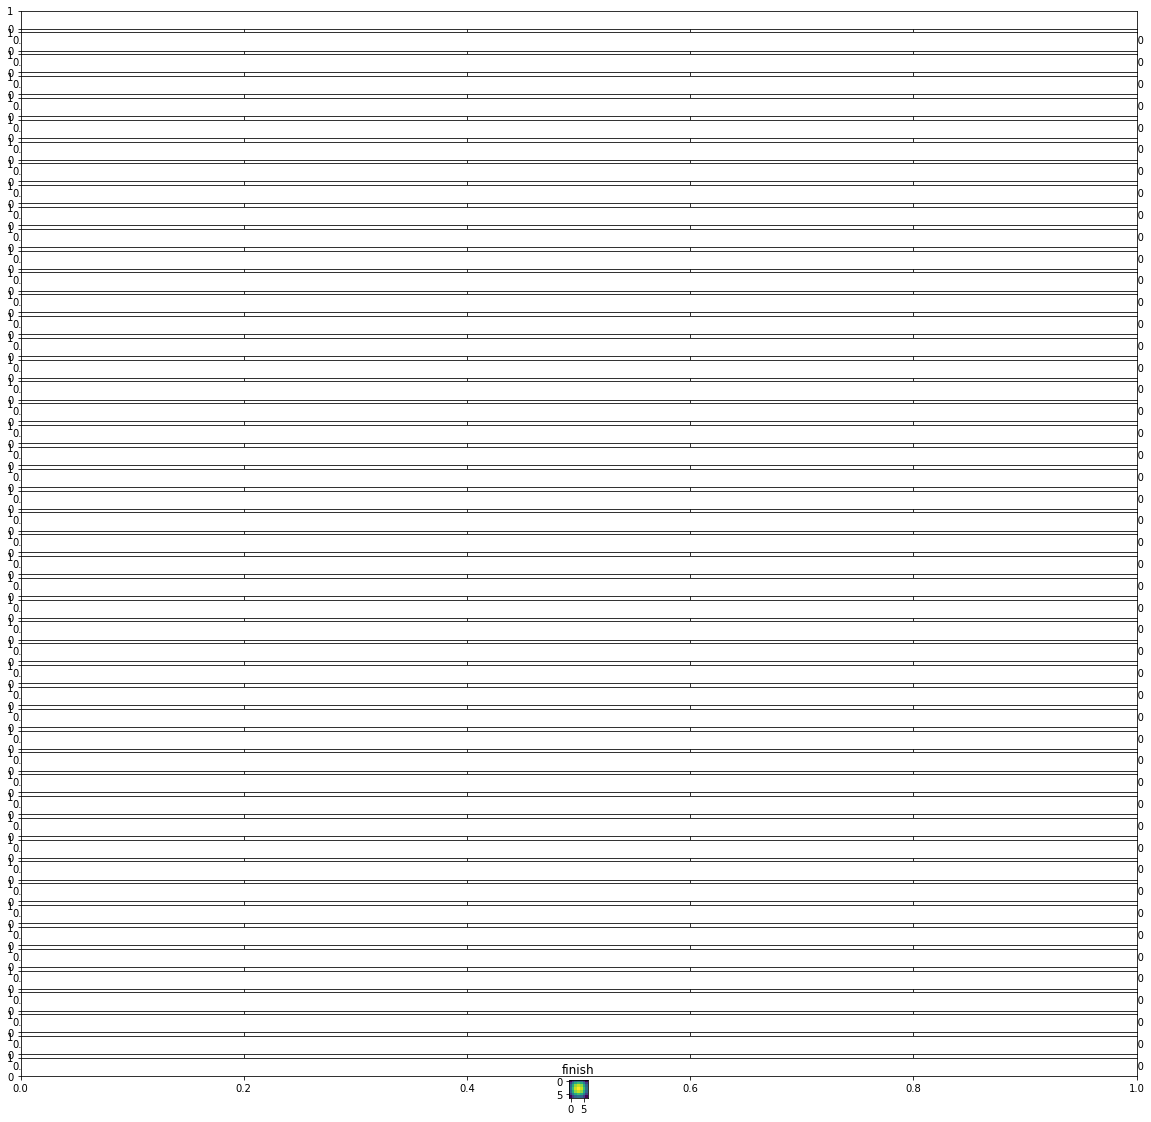

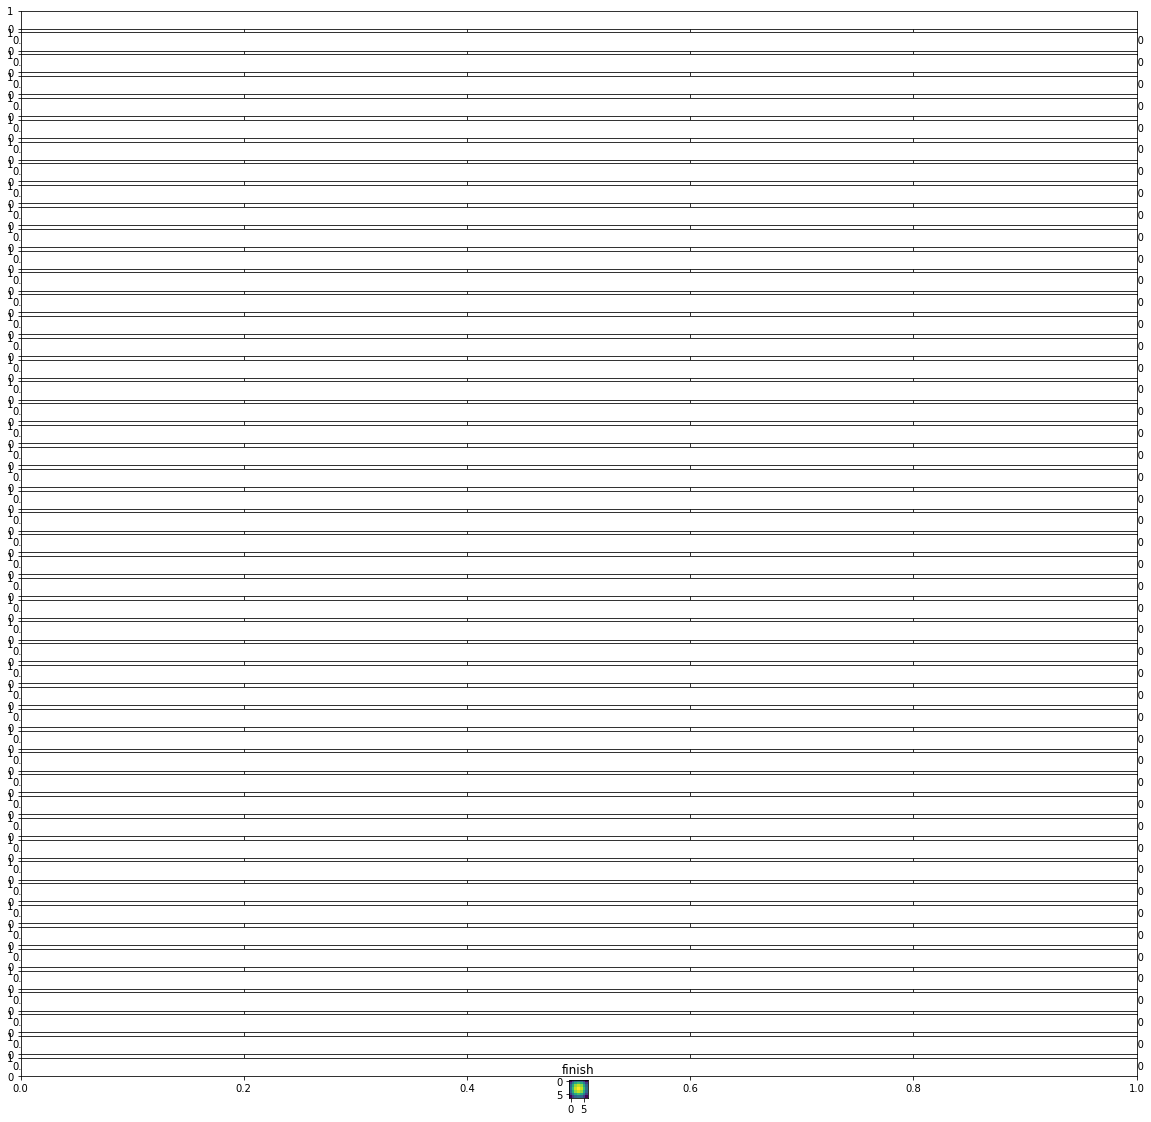

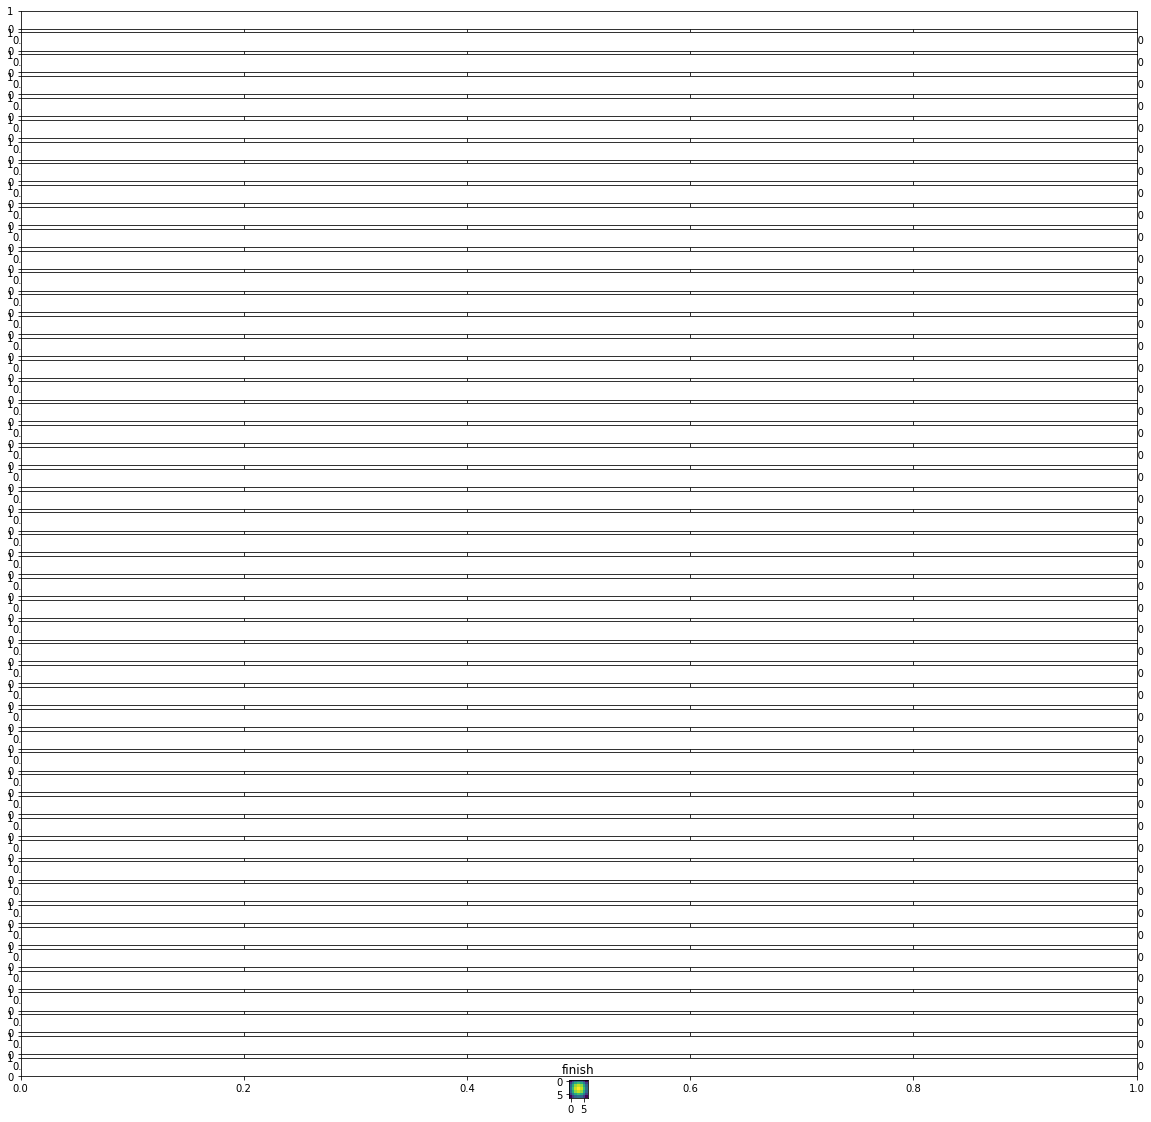

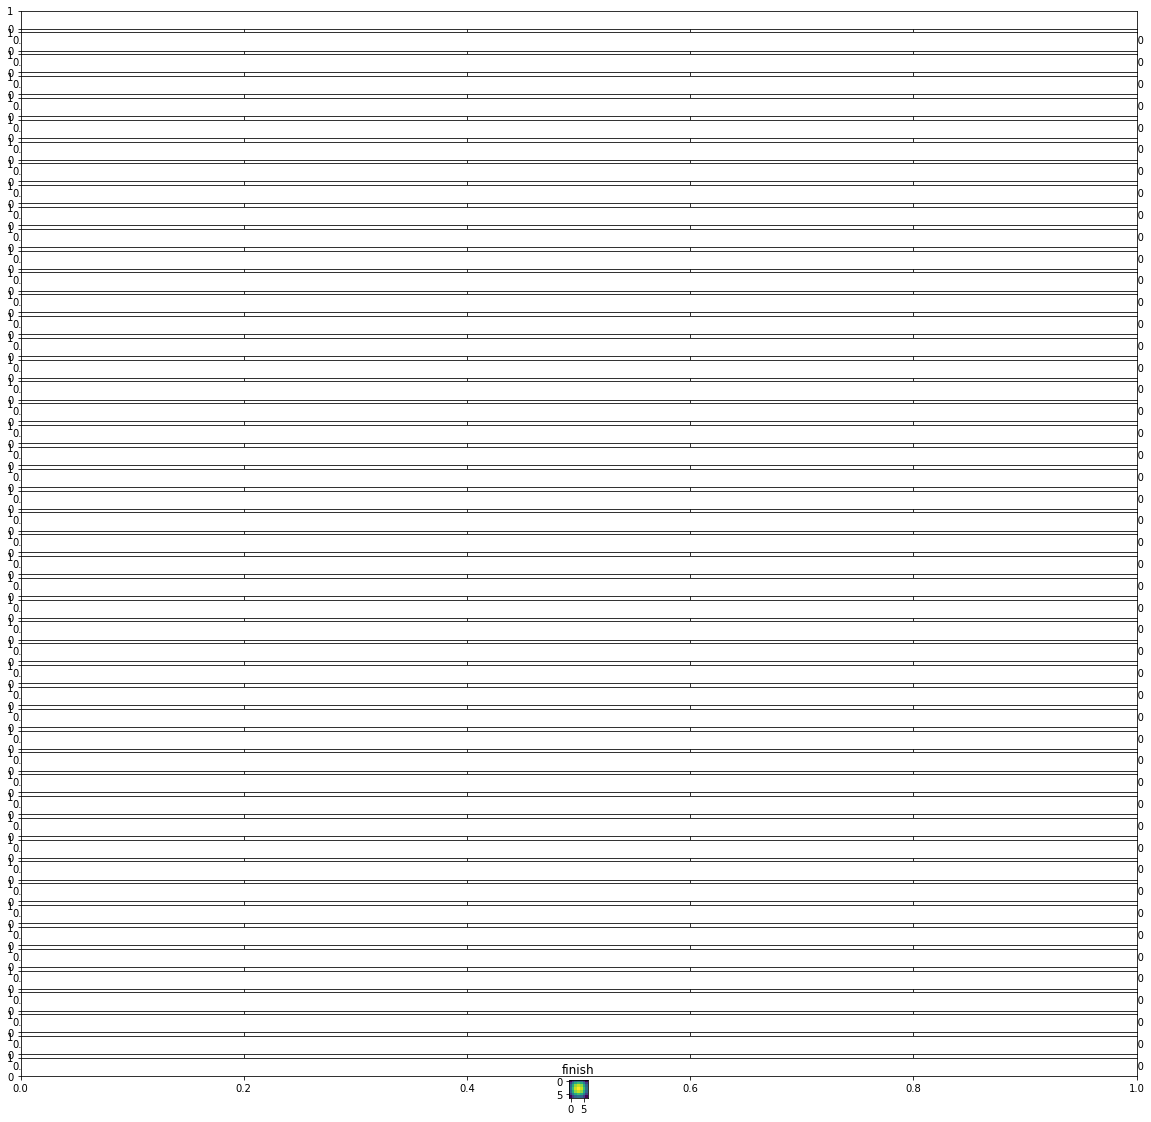

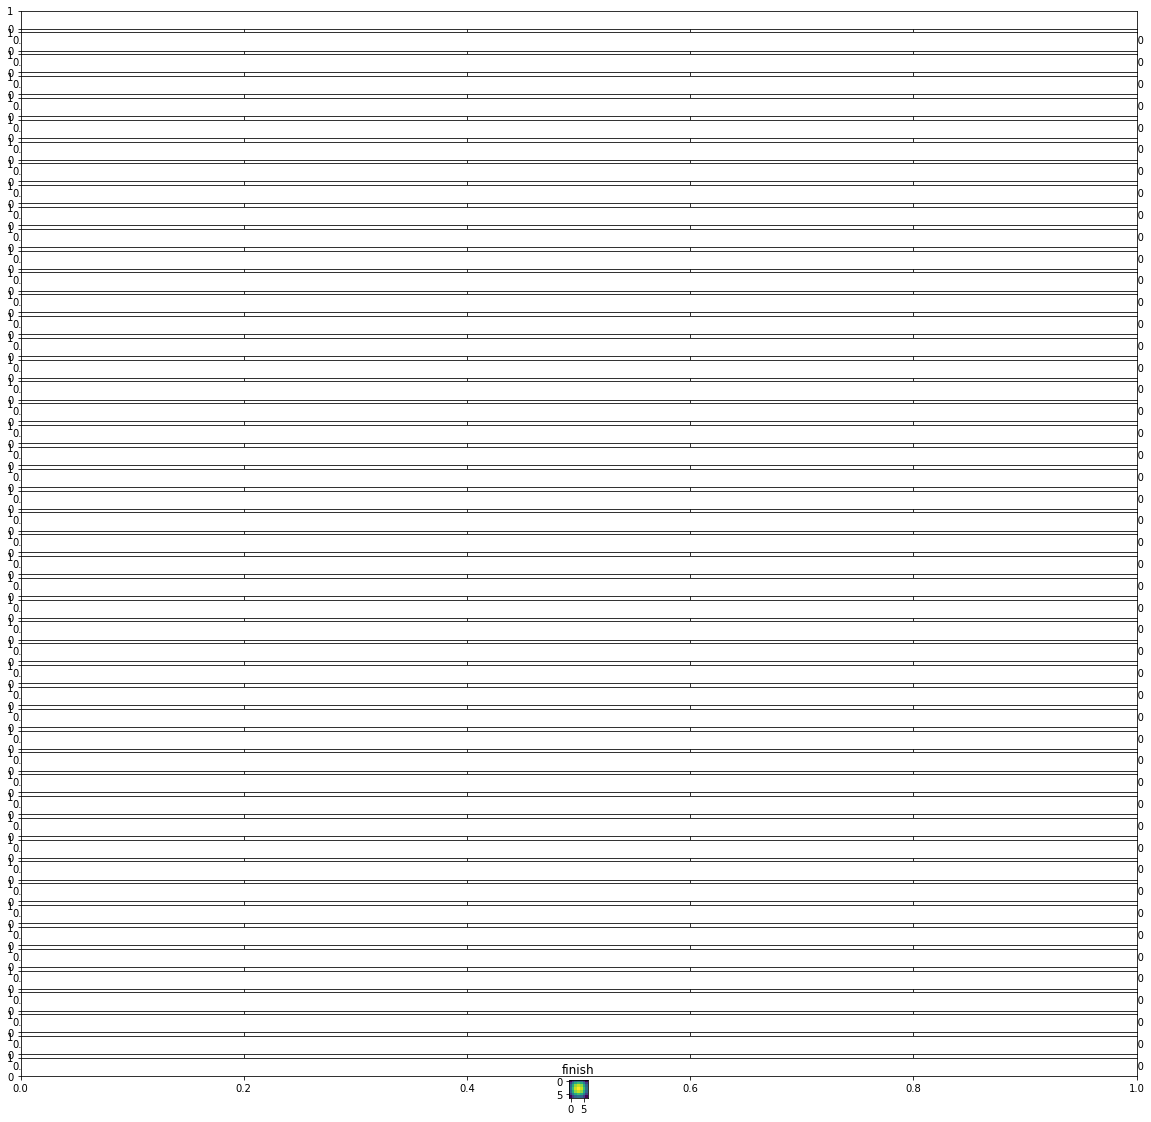

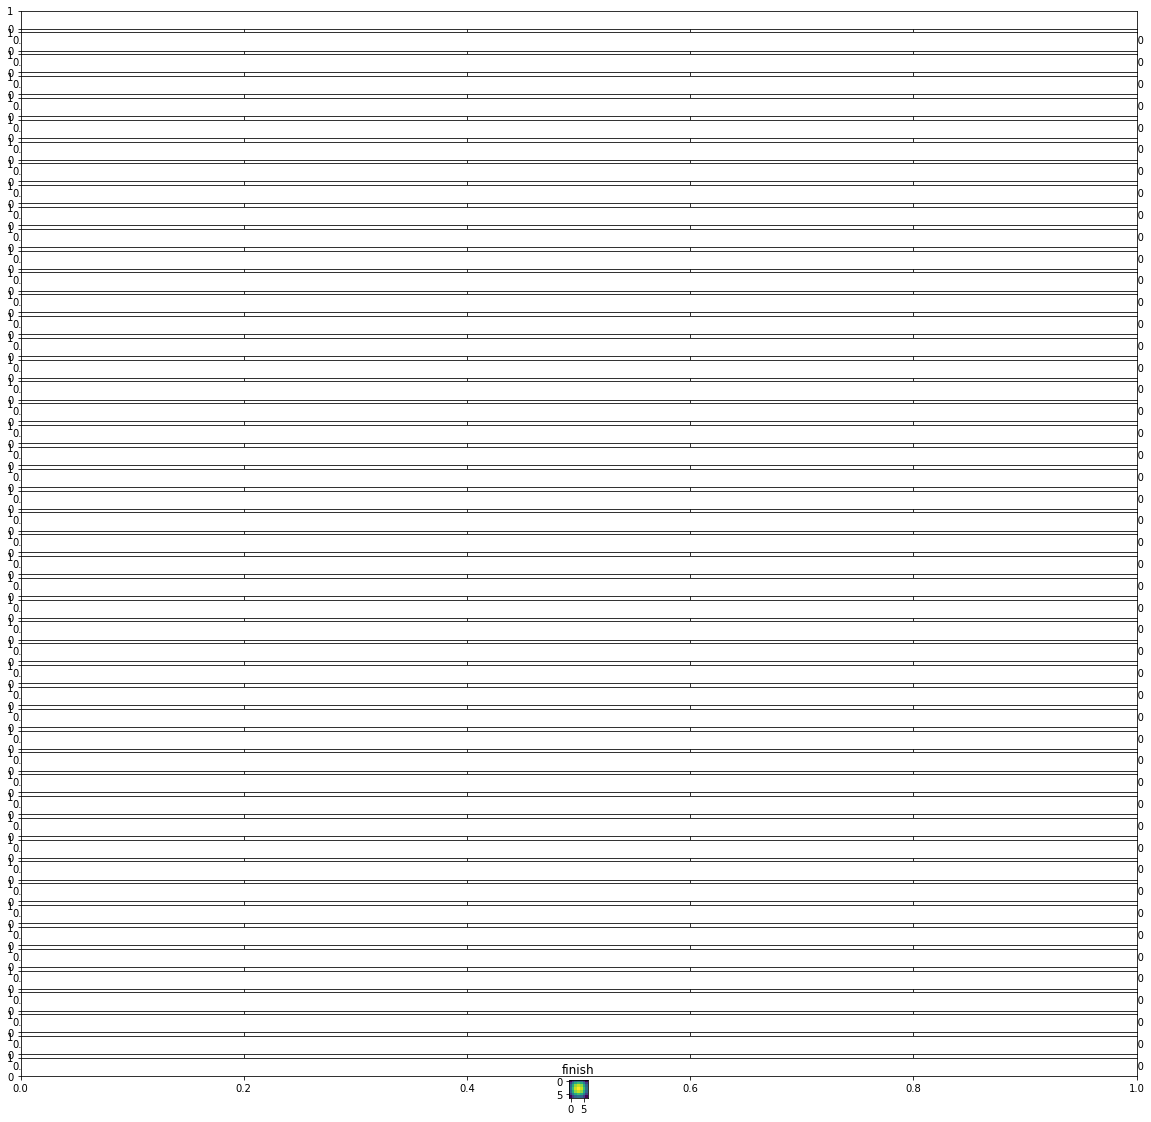

In [19]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
shape = [batch_size, image_size, image_size, num_channels]

# Construct a 7-layer CNN.
# C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# S2: sub-sampling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# S4: sub-sampling layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# F6: fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
  layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
  layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

  s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
  s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
  s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
  s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
  s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')
  
  # Model.
  def model(data, keep_prob, shape):
    LCN = LecunLCN(data, shape)
    conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
    hidden = tf.nn.relu(conv + layer1_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
    conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
    hidden = tf.nn.relu(conv + layer2_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
    conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
    hidden = tf.nn.relu(conv + layer3_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    logits1 = tf.matmul(reshape, s1_w) + s1_b
    logits2 = tf.matmul(reshape, s2_w) + s2_b
    logits3 = tf.matmul(reshape, s3_w) + s3_b
    logits4 = tf.matmul(reshape, s4_w) + s4_b
    logits5 = tf.matmul(reshape, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]
  
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.875, shape)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=tf_train_labels[:,1])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=tf_train_labels[:,2])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=tf_train_labels[:,3])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=tf_train_labels[:,4])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=tf_train_labels[:,5]))
    
  # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
    # TODO pack 
  train_prediction = tf.stack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
  valid_prediction = tf.stack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
  test_prediction = tf.stack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
  saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
#   saver.restore(session, "CNN_multi2.ckpt")
  saver.restore(session, "./model/CNN_multi.ckpt")
#   reader = tf.train.NewCheckpointReader("CNN_multi.ckpt")
  print("Model restored.")  

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 10000 == 0): 
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,1:6]))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  save_path = saver.save(session, "./model/CNN_multi2.ckpt")
  print("Model saved in file: %s" % save_path)

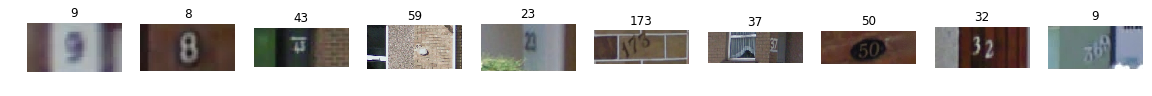

In [20]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = str(j+1)+'.png'
    fullname = os.path.join('./data/test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[j,0]):
        house_num += str(int(test_labels[j,int(k)+1]))
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

INFO:tensorflow:Restoring parameters from ./model/CNN_multi2.ckpt
Model restored.
Initialized
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


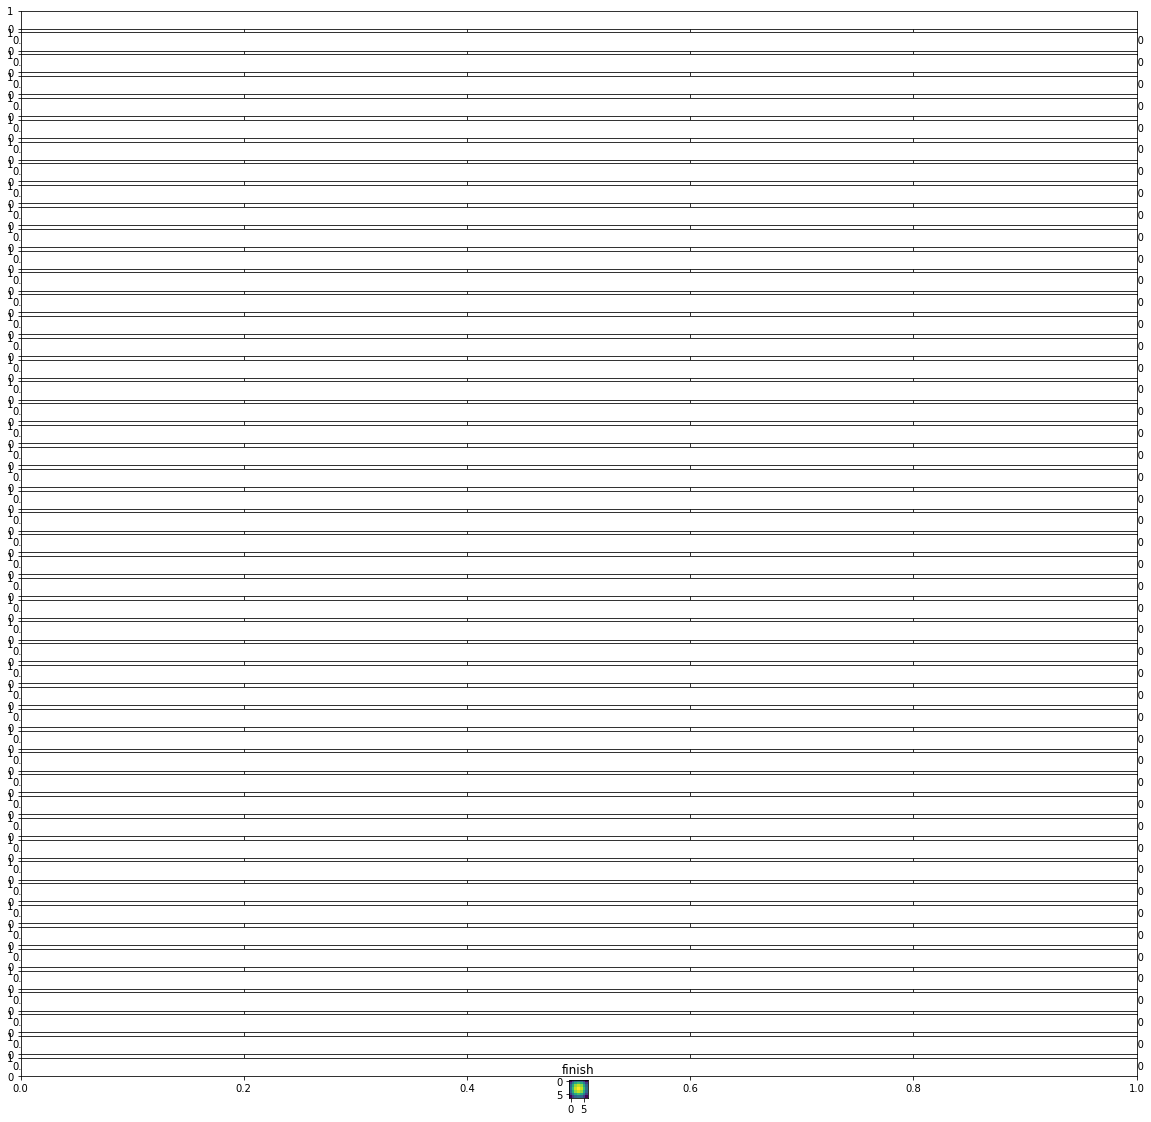

In [22]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64

graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_test_dataset = tf.placeholder(tf.float32, shape=(10, 32, 32, 1))
  
  # Variables.
  layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
  layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
  layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

  s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
  s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
  s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
  s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
  s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')
  
  # Model.
  def model(data, keep_prob, shape):
    LCN = LecunLCN(data, shape)
    conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
    hidden = tf.nn.relu(conv + layer1_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
    conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
    hidden = tf.nn.relu(conv + layer2_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
    conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
    hidden = tf.nn.relu(conv + layer3_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    logits1 = tf.matmul(reshape, s1_w) + s1_b
    logits2 = tf.matmul(reshape, s2_w) + s2_b
    logits3 = tf.matmul(reshape, s3_w) + s3_b
    logits4 = tf.matmul(reshape, s4_w) + s4_b
    logits5 = tf.matmul(reshape, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]
  
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_test_dataset, 1, [10, 32, 32, 1])
  
  # TODO
  predict = tf.stack([tf.nn.softmax(logits1),tf.nn.softmax(logits2),tf.nn.softmax(logits3),\
                         tf.nn.softmax(logits4),tf.nn.softmax(logits5)])
  test_prediction = tf.transpose(tf.argmax(predict, 2))
  saver = tf.train.Saver()

with tf.Session(graph=graph) as session:
  saver.restore(session, "./model/CNN_multi2.ckpt")
  print("Model restored.")  

  print('Initialized')
  test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
  print(test_prediction)

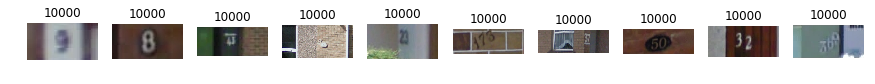

In [25]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    filename = str(j+1)+'.png'
    fullname = os.path.join('./data/test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(np.sum(test_prediction[i,:] != 10)):
        house_num += str(test_prediction[i,k])

    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)